<a href="https://colab.research.google.com/github/csnanmu/csnanmu/blob/main/DL4H_Team_136.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DL4H_Team_136 Gimlet: A unified graph-text model for instruction-based molecule zero-shot learning

### Team Member
* Nan Mu(nanmu2@illinois.edu)
* Ruqian Cheng (ruqianc2@illinois.edu)

Video Representation: https://mediaspace.illinois.edu/media/t/1_7rhinu8d

Link to the google drive folder contains dataset and colab:

https://drive.google.com/drive/folders/18GAdnJBlnigaF5ZZ0_m8mG5IOE1ZhI5N?usp=sharing

This colab can be run end to end after mount this google drive folder to colab runtime.


Link to this colab in google drive:

https://colab.research.google.com/drive/1bhVXhgOTuEDiygYUOWVXq_aU3imLvubc?usp=sharing



# Introduction
*   Background of the problem


Predicting molecular properties is a critical yet challenging aspect of drug discovery, hindered significantly by the scarcity of labeled data, which typically comes from costly and time-consuming laboratory experiments. Current models are often inadequate in settings where labeled data is minimal, particularly in zero-shot scenarios where the model must perform tasks using natural language instructions without prior specific training. This challenge is compounded by the limitations of existing models that struggle to effectively integrate complex instructions with the intricate details of molecular graphs.

*   Paper explanation


The paper presents GIMLET, an innovative model that integrates natural language instructions with molecular graph data to predict molecular properties, thereby minimizing the reliance on extensive labeled datasets. By leveraging a pretraining strategy on a diverse dataset that includes both molecular tasks and corresponding instructions, GIMLET facilitates zero-shot learning, enabling it to predict properties of new molecules without direct prior exposure. This approach not only addresses the issue of data scarcity but also streamlines the process of drug discovery and chemical analysis, offering a more efficient pathway through the use of enriched natural language processing and graph analysis techniques.


# Scope of Reproducibility:
This section outlines the hypothesis to be tested and the corresponding experiments to be conducted.

## Hypothesis

1. Hypothesis 1: GIMLET model has better performance using few show prompts vs zero shot prompts
2. Hypothesis 2: GIMLET model is robust to test against variations of prompts than the original prompts it was trained on.


## Planned Experiments
1. Compare the original GIMLET model with Few shots (4 shot, 8 shot) trained models. For a dataset that GIMLET model doesn't pre-trained for, split into training and test set. Using training set to train 4/8 prompts per molecule models for each molecule. Compare the performance on the test set.
2. Augment existing prompts in the test set using rewrite, expand, detail, shorten transformations. Test the performace of the models on the new test set.

# Methodology

The methodology consists of run-able codes with necessary annotations to show the experiment executed for testing the hypotheses.

## Environment


### Python Version

Python version 3.10.12

In [ ]:
import sys
print(sys.version)

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]



### Import Python Dependencies


#### Install Missing Python Packages

In [ ]:
! pip install pytorch-lightning wandb rdkit ogb datasets
import torch
VERSION = torch.__version__
! pip install torch_scatter torch_sparse -f https://data.pyg.org/whl/torch-{VERSION}.html
! pip install torch_geometric==1.7.2
! pip install transformers[torch]
! pip install commentjson

Looking in links: https://data.pyg.org/whl/torch-2.2.1+cu121.html


#### Import Python Libraries

In [ ]:
import commentjson
import datasets
import math
import logging
import os
import os.path as osp
import sys
import warnings
import re
import numpy as np
import pandas as pd
import scipy
import setuptools
import faulthandler
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import time
import pyximport
import argparse

import pickle
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from multiprocessing import Pool
# import argparse
from rdkit.Chem.Scaffolds import MurckoScaffold


from collections.abc import Mapping, Sequence
from dataclasses import dataclass, field
from datasets import load_dataset,DatasetDict
from itertools import chain
from typing import Optional,Tuple, List
from sklearn.metrics import (roc_auc_score,f1_score,confusion_matrix,r2_score)
from tqdm import tqdm
from ogb.utils import smiles2graph
from rdkit import Chem

import transformers
from transformers import (
    CONFIG_MAPPING,
    MODEL_FOR_MASKED_LM_MAPPING,
    AutoConfig,
    AutoModelForMaskedLM,
    DataCollatorForLanguageModeling,
    HfArgumentParser,
    T5ForConditionalGeneration,
    Trainer,
    TrainingArguments,
    is_torch_tpu_available,
    set_seed,
)
from transformers.modeling_outputs import (
    BaseModelOutput,
    Seq2SeqLMOutput,
    BaseModelOutputWithPastAndCrossAttentions
)
from transformers.models.t5.modeling_t5 import T5Stack
from transformers.tokenization_utils_base import BatchEncoding
from transformers.trainer_utils import get_last_checkpoint
from transformers.utils import check_min_version, send_example_telemetry, logging
from transformers.utils.versions import require_version
from transformers import AutoTokenizer, PretrainedConfig

import torch.utils.data
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
import torch
from torch import nn, Tensor
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F
from torch.utils.checkpoint import checkpoint
from torch_geometric.data import (Data, Batch, InMemoryDataset, download_url,
                                  extract_gz)
from torch_geometric.datasets.molecule_net import x_map,e_map


In [ ]:
logger = logging.get_logger(__name__)

### Mount Notebook to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/MyDrive/DL4H_Team_136/chembl_dataset"

ablated_prompt_downstream_task.json    chembl_pretraining.parquet  tox21.parquet
augmented_prompt_downstream_task.json  hiv.parquet		   toxcast.parquet


##  Data
Data includes raw data (ChEMBL), source of the data, descriptive statistics and data processing.

### Source of the Data

The dataset is sourced from ChEMBL, a large-scale bioactivity database containing information about bioactive drug-like small molecules. It includes the chemical structures of molecules, their biological activities, calculated properties, and drug targets. The dataset was initially downloaded from http://bioinf.jku.at/research/lsc/chembl20/. The downloaded raw data includes the following:


In [ ]:
!ls "/content/drive/MyDrive/DL4H_Team_136/chembl_raw"

checksums.md5	     ecfp6.pckl		      labelsWeakHard.mtx	  samples.pckl
chembl20LSTM.pckl    folds0.pckl	      labelsWeakHard.pckl	  semi.pckl
chembl20Smiles.pckl  labelsHard.pckl	      labelsWeakHard.targetNames  static.pckl
dfs8.pckl	     labelsWeakHard.cmpNames  mol_cluster.csv		  tox.pckl


### Data Processing

1. The transformation process of the ChEMBL dataset:
* Remove entries with missing data (None values).
* Exclude molecules with two or fewer non-hydrogen atoms.
* For compounds with multiple components, keep only the largest molecule.
* Filter out molecules outside the desired molecular weight range (below 50 or above 900).

2. Map ChEMBL IDs to STRING IDs, facilitating a bridge between ChEMBL's biochemical data and STRING's protein interaction data. The process involves:
* Map Targets to Indices: Create a list from target annotation indices and write a mapping of each target to a corresponding index into a new file. This step organizes the data for easy reference.
* Verify SMILES Strings: Open a file containing SMILES strings and another with molecular representations. By iterating over these, the script checks that each SMILES string correctly matches its molecular structure as represented by RDKit objects, ensuring the data's accuracy and consistency.

3. Simplifies the ChEMBL dataset:
* Create Connected Subsets: Generate ChEMBL-Dense-{10, 50, 100} datasets based on connectivity.
* Filtering: Keep only well-connected drug and assay tasks.
* Resulting Datasets: Obtain three refined datasets with specific connectivity levels.

### Descriptive Statistics

We chose to focus on a specific task within the dataset known as Tox21, which examines the potential of certain molecules to engage the antioxidant response element (ARE) signaling pathway. This pathway plays a vital role in mitigating oxidative stress, a factor involved in a wide range of diseases from cancer to neurodegeneration. The objective is to determine whether a given molecule acts as an agonist to the ARE signaling pathway.

Description of Tox21 dataset:

1. graph: Contains SMILES notations representing the molecular structures.
2. text: Descriptive text providing context or instructions related to the molecule's biological interactions.
3. label: Indicates whether the molecule acts as an agonist (Yes) or not (No) to the biological target described in the text.
4. dataset_name: Names the dataset, 'tox21' in this case, which focuses on understanding chemical effects on human health.
5. task_index: An identifier for the specific biological assay within the dataset.
6. molecule_index: A unique identifier for each molecule in the dataset.
7. split: Designates the subset (train, validation, test) to which the data point belongs, for use in model training and evaluation.

In [ ]:
import pandas as pd
tox21 = pd.read_parquet('/content/drive/MyDrive/DL4H_Team_136/chembl_dataset/tox21.parquet', engine='pyarrow')

In [ ]:
# Display the first five entries for reference
tox21.head()

,graph,text,label,dataset_name,task_index,molecule_index,split
0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,[Estrogen receptor alpha (ER aplha) is Nuclear...,No,tox21,0,0,train
1,CCN1C(=O)NC(c2ccccc2)C1=O,[Estrogen receptor alpha (ER aplha) is Nuclear...,No,tox21,0,1,train
2,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C,[Estrogen receptor alpha (ER aplha) is Nuclear...,No,tox21,0,3,train
3,CC(O)(P(=O)(O)O)P(=O)(O)O,[Estrogen receptor alpha (ER aplha) is Nuclear...,No,tox21,0,4,train
4,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C,[Estrogen receptor alpha (ER aplha) is Nuclear...,No,tox21,0,5,train


In [ ]:
# Calculate basic statistics
total_observations = tox21.shape[0]
train_split_size = tox21[tox21['split'] == 'train'].shape[0]
validation_split_size = tox21[tox21['split'] == 'valid'].shape[0]  # if 'valid' is a split type
test_split_size = tox21[tox21['split'] == 'test'].shape[0]         # if 'test' is a split type
label_distribution = tox21['label'].value_counts()

# Print the basic statistics
print(f"Total Observations: {total_observations}")
print(f"Training Set Size: {train_split_size}")
print(f"Validation Set Size: {validation_split_size}")
print(f"Test Set Size: {test_split_size}")
print("Label Distribution:", label_distribution)

Total Observations: 77946
Training Set Size: 63733
Validation Set Size: 7144
Test Set Size: 7069
Label Distribution: label
No     72084
Yes     5862
Name: count, dtype: int64


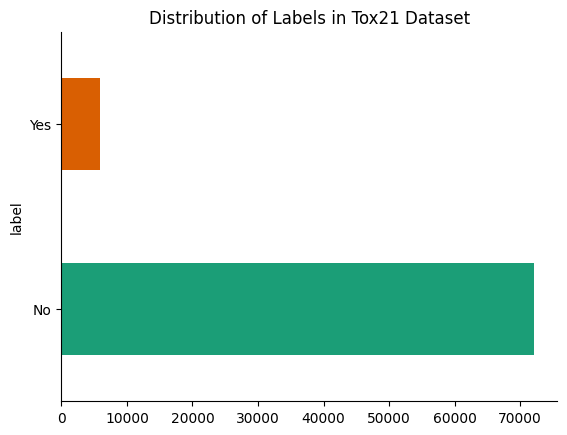

In [ ]:
# Labels Distribution
tox21.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.title('Distribution of Labels in Tox21 Dataset')
plt.gca().spines[['top', 'right',]].set_visible(False)

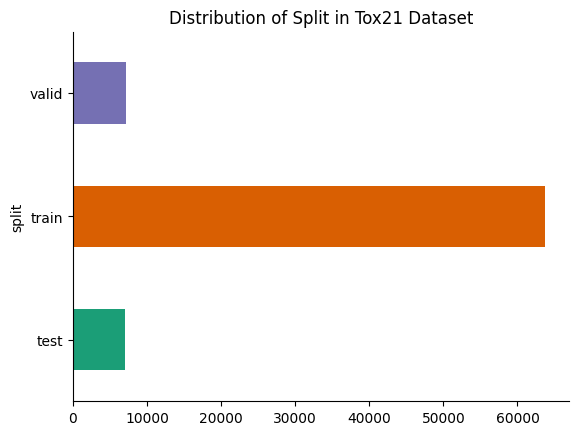

In [ ]:
# Split Distribution
tox21.groupby('split').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.title('Distribution of Split in Tox21 Dataset')
plt.gca().spines[['top', 'right',]].set_visible(False)

### Tokenizer

In [ ]:
tokenizer_kwargs = {
        "cache_dir": None,
        "use_fast": True,
        "revision": 'main',
        "use_auth_token": None,
    }
tokenizer = AutoTokenizer.from_pretrained("t5-small", **tokenizer_kwargs)

### Data Collator

In [ ]:
def tokenize_function_gimlet(examples, tokenizer, text_column_name, padding, max_seq_length, rich_features, transform_in_collator):
    # Remove empty lines
    # examples[text_column_name] = [line for line in examples[text_column_name] if len(line) > 0 and not line.isspace()]
    text = tokenizer(
        examples[text_column_name] if isinstance(examples[text_column_name],str) else examples[text_column_name][0], # if examples[text_column_name] is list
        padding=padding,
        truncation=True,
        max_length=max_seq_length,
        # We use this option because DataCollatorForLanguageModeling (see below) is more efficient when it
        # receives the `special_tokens_mask`.
        return_special_tokens_mask=True,
    )
    labels = tokenizer(
        str(examples['label']),
        padding=padding,
        truncation=True,
        max_length=max_seq_length,
        # We use this option because DataCollatorForLanguageModeling (see below) is more efficient when it
        # receives the `special_tokens_mask`.
        return_special_tokens_mask=True,
    )


    graph_data = examples['graph']

    return {'graph': graph_data,
            'input_ids': text.data['input_ids'],
            'attention_mask': text.data['attention_mask'],
            'special_tokens_mask': text.data['special_tokens_mask'],
            'labels': labels.data['input_ids']}

In [ ]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [ ]:
%%cython
import cython
from cython.parallel cimport prange, parallel
cimport numpy
import numpy

def floyd_warshall(adjacency_matrix):

    (nrows, ncols) = adjacency_matrix.shape
    assert nrows == ncols
    cdef unsigned int n = nrows

    adj_mat_copy = adjacency_matrix.astype(long, order='C', casting='safe', copy=True)
    assert adj_mat_copy.flags['C_CONTIGUOUS']
    cdef numpy.ndarray[long, ndim=2, mode='c'] M = adj_mat_copy
    cdef numpy.ndarray[long, ndim=2, mode='c'] path = -1 * numpy.ones([n, n], dtype=numpy.int64)

    cdef unsigned int i, j, k
    cdef long M_ij, M_ik, cost_ikkj
    cdef long* M_ptr = &M[0,0]
    cdef long* M_i_ptr
    cdef long* M_k_ptr

    # set unreachable nodes distance to 510
    for i in range(n):
        for j in range(n):
            if i == j:
                M[i][j] = 0
            elif M[i][j] == 0:
                M[i][j] = 510

    # floyed algo
    for k in range(n):
        M_k_ptr = M_ptr + n*k
        for i in range(n):
            M_i_ptr = M_ptr + n*i
            M_ik = M_i_ptr[k]
            for j in range(n):
                cost_ikkj = M_ik + M_k_ptr[j]
                M_ij = M_i_ptr[j]
                if M_ij > cost_ikkj:
                    M_i_ptr[j] = cost_ikkj
                    path[i][j] = k

    # set unreachable path to 510
    for i in range(n):
        for j in range(n):
            if M[i][j] >= 510:
                path[i][j] = 510
                M[i][j] = 510

    return M, path


def get_all_edges(path, i, j):
    cdef int k = path[i][j]
    if k == -1:
        return []
    else:
        return get_all_edges(path, i, k) + [k] + get_all_edges(path, k, j)


def gen_edge_input(max_dist, path, edge_feat):

    (nrows, ncols) = path.shape
    assert nrows == ncols
    cdef unsigned int n = nrows
    cdef unsigned int max_dist_copy = max_dist

    path_copy = path.astype(long, order='C', casting='safe', copy=True)
    edge_feat_copy = edge_feat.astype(long, order='C', casting='safe', copy=True)
    assert path_copy.flags['C_CONTIGUOUS']
    assert edge_feat_copy.flags['C_CONTIGUOUS']

    cdef numpy.ndarray[long, ndim=4, mode='c'] edge_fea_all = -1 * numpy.ones([n, n, max_dist_copy, edge_feat.shape[-1]], dtype=numpy.int64)
    cdef unsigned int i, j, k, num_path, cur

    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            if path_copy[i][j] == 510:
                continue
            path = [i] + get_all_edges(path_copy, i, j) + [j]
            num_path = len(path) - 1
            for k in range(num_path):
                edge_fea_all[i, j, k, :] = edge_feat_copy[path[k], path[k+1], :]

    return edge_fea_all

In [ ]:
def convert_to_single_emb(x, offset: int = 512):
    feature_num = x.shape[1] if len(x.shape) > 1 else 1
    feature_offset = (1 + np.arange(0, feature_num * offset, offset)).astype("long")
    x = x + feature_offset
    return x

def graphormer_data_transform_tensor(item,rich_features=False):
    if 'node_feat' in item and 'edge_feat' in item:
        edge_attr, edge_index, x = item['edge_feat'].long(), item['edge_index'].long(), item['node_feat'].long()
    elif hasattr(item, 'x') and hasattr(item, 'edge_attr'):
        edge_attr, edge_index, x = item.edge_attr.long(), item.edge_index.long(), item.x.long()
    else:
        raise ValueError('item does not have expected keys or properties')

    if not rich_features:
        x = x[:,0:2]
        edge_attr = edge_attr[:,0:2]


    N = x.size(0)
    x = convert_to_single_emb(x)

    # node adj matrix [N, N] bool
    adj = torch.zeros([N, N], dtype=torch.bool)
    adj[edge_index[0, :], edge_index[1, :]] = True

    # edge feature here
    if len(edge_attr.size()) == 1:
        edge_attr = edge_attr[:, None]
    attn_edge_type = torch.zeros([N, N, edge_attr.size(-1)], dtype=torch.long)
    attn_edge_type[edge_index[0, :], edge_index[1, :]] = (
        convert_to_single_emb(edge_attr) + 1
    )

    shortest_path_result, path = floyd_warshall(adj.numpy())
    max_dist = np.amax(shortest_path_result)
    edge_input = gen_edge_input(max_dist, path, attn_edge_type.numpy())
    spatial_pos = torch.from_numpy((shortest_path_result)).long()
    attn_bias = torch.zeros([N + 1, N + 1], dtype=torch.float)  # with graph token

    # combine
    item.x = x
    item.attn_bias = attn_bias
    item.attn_edge_type = attn_edge_type
    item.spatial_pos = spatial_pos
    item.in_degree = adj.long().sum(dim=1).view(-1)
    item.out_degree = item.in_degree  # for undirected graph
    item.edge_input = torch.from_numpy(edge_input).long()

    return item

In [ ]:
def pad_1d_unsqueeze(x, padlen):
    x = x + 1  # pad id = 0
    xlen = x.size(0)
    if xlen < padlen:
        new_x = x.new_zeros([padlen], dtype=x.dtype)
        new_x[:xlen] = x
        x = new_x
    return x.unsqueeze(0)


def pad_2d_unsqueeze(x, padlen):
    x = x + 1  # pad id = 0
    xlen, xdim = x.size()
    if xlen < padlen:
        new_x = x.new_zeros([padlen, xdim], dtype=x.dtype)
        new_x[:xlen, :] = x
        x = new_x
    return x.unsqueeze(0)


def pad_attn_bias_unsqueeze(x, padlen):
    xlen = x.size(0)
    if xlen < padlen:
        new_x = x.new_zeros([padlen, padlen], dtype=x.dtype).fill_(float("-inf"))
        new_x[:xlen, :xlen] = x
        new_x[xlen:, :xlen] = 0
        x = new_x
    return x.unsqueeze(0)


def pad_edge_type_unsqueeze(x, padlen):
    xlen = x.size(0)
    if xlen < padlen:
        new_x = x.new_zeros([padlen, padlen, x.size(-1)], dtype=x.dtype)
        new_x[:xlen, :xlen, :] = x
        x = new_x
    return x.unsqueeze(0)


def pad_spatial_pos_unsqueeze(x, padlen):
    x = x + 1
    xlen = x.size(0)
    if xlen < padlen:
        new_x = x.new_zeros([padlen, padlen], dtype=x.dtype)
        new_x[:xlen, :xlen] = x
        x = new_x
    return x.unsqueeze(0)


def pad_3d_unsqueeze(x, padlen1, padlen2, padlen3):

    x = x + 1
    xlen1, xlen2, xlen3, xlen4 = x.size()
    if xlen1 < padlen1 or xlen2 < padlen2 or xlen3 < padlen3:
        # new_x = x.new_zeros([padlen1, padlen2, padlen3, xlen4], dtype=x.dtype)
        # new_x[:xlen1, :xlen2, :xlen3, :] = x
        # x = new_x
        x = torch.nn.functional.pad(
            x,
            pad=(0,0, 0, padlen3 - xlen3,0, padlen2 - xlen2,0, padlen1 - xlen1, ),
            mode='constant',
            value=0
        )

    return x.unsqueeze(0)

def pad_3d_sequences(xs, padlen1, padlen2, padlen3):
    result=torch.zeros([len(xs),padlen1,padlen2,padlen3,xs[0].shape[-1]], dtype=xs[0].dtype)
    for i,x in enumerate(xs):
        result[i,:x.shape[0], :x.shape[1], :x.shape[2], :]=x+1
    return result


def pad(encoded_inputs,
        pad_token_id,
        pad_token_type_id,
        max_length: Optional = None,
        pad_to_multiple_of: Optional = None,
        return_attention_mask: Optional = None,
        padding_side='right',
        ):
    if return_attention_mask is None:
        return_attention_mask = "attention_mask" in encoded_inputs

    required_input = encoded_inputs[list(encoded_inputs.keys())[0]]


    if max_length is not None and pad_to_multiple_of is not None and (max_length % pad_to_multiple_of != 0):
        max_length = ((max_length // pad_to_multiple_of) + 1) * pad_to_multiple_of

    needs_to_be_padded =  len(required_input) != max_length

    # Initialize attention mask if not present.
    if return_attention_mask and "attention_mask" not in encoded_inputs:
        encoded_inputs["attention_mask"] = [1] * len(required_input)

    if needs_to_be_padded:
        difference = max_length - len(required_input)

        if padding_side == "right":
            if return_attention_mask:
                encoded_inputs["attention_mask"] = encoded_inputs["attention_mask"] + [0] * difference
            if "token_type_ids" in encoded_inputs:
                encoded_inputs["token_type_ids"] = (
                        encoded_inputs["token_type_ids"] + [pad_token_type_id] * difference
                )
            if "special_tokens_mask" in encoded_inputs:
                encoded_inputs["special_tokens_mask"] = encoded_inputs["special_tokens_mask"] + [1] * difference
            if "answer_mask" in encoded_inputs:
                encoded_inputs["answer_mask"] = encoded_inputs["answer_mask"] + [0] * difference
            if "input_ids" in encoded_inputs:
                encoded_inputs['input_ids'] = encoded_inputs['input_ids'] + [pad_token_id] * difference
            if "labels" in encoded_inputs:
                encoded_inputs['labels'] = encoded_inputs['labels'] + [-100] * difference #-100 can makesure that generation loss will not consider padded position
            if 'decoder_attention_mask' in encoded_inputs:
                encoded_inputs['decoder_attention_mask'] = encoded_inputs['decoder_attention_mask']+[0]*difference


        else:
            raise ValueError("Invalid padding strategy:" + str(padding_side))

    return encoded_inputs

def padding(encoded_inputs,
        pad_token_id,
        pad_token_type_id,
        max_length: Optional = None,
        pad_to_multiple_of: Optional = None,
        return_attention_mask: Optional = None):
    if isinstance(encoded_inputs, (list, tuple)) and isinstance(encoded_inputs[0], Mapping):
        encoded_inputs = {key: [example[key] for example in encoded_inputs] for key in encoded_inputs[0].keys()}


    required_input = encoded_inputs[list(encoded_inputs.keys())[0]]
    if required_input and not isinstance(required_input[0], (list, tuple)):
        encoded_inputs = pad(
            encoded_inputs,
            pad_token_id,
            pad_token_type_id,
            max_length=max_length,
            pad_to_multiple_of=pad_to_multiple_of,
            return_attention_mask=return_attention_mask,
        )
        return BatchEncoding(encoded_inputs, tensor_type='pt')

    batch_size = len(required_input)
    max_length = max(len(inputs) for inputs in required_input)
    # padding_strategy = PaddingStrategy.MAX_LENGTH


    batch_outputs = {}
    for i in range(batch_size):
        inputs = dict((k, v[i]) for k, v in encoded_inputs.items())
        outputs = pad(
            inputs,
            pad_token_id,
            pad_token_type_id,
            max_length=max_length,
            pad_to_multiple_of=pad_to_multiple_of,
            return_attention_mask=return_attention_mask,
        )

        for key, value in outputs.items():
            if key not in batch_outputs:
                batch_outputs[key] = []
            batch_outputs[key].append(value)
    return BatchEncoding(batch_outputs, tensor_type='pt')


def collator_graph_data(items, max_node=512, multi_hop_max_dist=20, spatial_pos_max=20,transform_in_collator=False,include_y=False,rich_features=False):
    items_new=[]
    ys=[]

    for item in items:

        if transform_in_collator:
            if isinstance(item,str):
                item = smiles2graph(item)

        if include_y:
            ys.append(item.y)
        item_new = Data()
        if isinstance(item,Data):
            for key in item.keys:
                item_new[key]=torch.tensor(item[key]) if (not isinstance(item[key],torch.Tensor))  else item[key]
        else:
            for key in item.keys():
                item_new[key]=torch.tensor(item[key]) if (not isinstance(item[key],torch.Tensor))  else item[key]

        if transform_in_collator:
            # try:
            item_new = graphormer_data_transform_tensor(item_new,rich_features)
            # except:
            #     print('graph data error')
            #     print(item)
            #     continue

        items_new.append(item_new)



    items=items_new
    items = [item for item in items if item is not None and item['x'].size(0) <= max_node]
    items = [
        (
            # item.idx,
            item.attn_bias,
            item.attn_edge_type,
            item.spatial_pos,
            item.in_degree,
            item.out_degree,
            item.x,
            item.edge_input[:, :, :multi_hop_max_dist, :],
            # item.y,
        )
        for item in items
    ]
    (
        # idxs,
        attn_biases,
        attn_edge_types,
        spatial_poses,
        in_degrees,
        out_degrees,
        xs,
        edge_inputs,
        # ys,
    ) = zip(*items)

    for idx, _ in enumerate(attn_biases):
        attn_biases[idx][1:, 1:][spatial_poses[idx] >= spatial_pos_max] = float("-inf")

    max_node_num = max(i.size(0) for i in xs)
    max_dist = max(i.size(-2) for i in edge_inputs)

    # y = torch.cat(ys)
    x = torch.cat([pad_2d_unsqueeze(i, max_node_num) for i in xs])

    # edge_input_padded=[pad_3d_unsqueeze(i, max_node_num, max_node_num, max_dist) for i in edge_inputs]
    # edge_input_ori = torch.cat(edge_input_padded
    # )
    edge_input = pad_3d_sequences(edge_inputs,max_node_num, max_node_num, max_dist)
    # assert (edge_input_ori-edge_input).abs().sum()==0

    attn_bias = torch.cat(
        [pad_attn_bias_unsqueeze(i, max_node_num + 1) for i in attn_biases]
    )

    attn_edge_type = torch.cat(
        [pad_edge_type_unsqueeze(i, max_node_num) for i in attn_edge_types]
    )

    spatial_pos = torch.cat(
        [pad_spatial_pos_unsqueeze(i, max_node_num) for i in spatial_poses]
    )

    in_degree = torch.cat([pad_1d_unsqueeze(i, max_node_num) for i in in_degrees])


    if include_y:
        y = torch.cat(ys)
        return Data(
            # idx=torch.LongTensor(idxs),
            attn_bias=attn_bias,
            attn_edge_type=attn_edge_type,
            spatial_pos=spatial_pos,
            in_degree=in_degree,
            out_degree=in_degree,  # for undirected graph
            x=x,
            edge_input=edge_input,
            y=y,
        )
    else:
        return Data(
            # idx=torch.LongTensor(idxs),
            attn_bias=attn_bias,
            attn_edge_type=attn_edge_type,
            spatial_pos=spatial_pos,
            in_degree=in_degree,
            out_degree=in_degree,  # for undirected graph
            x=x,
            edge_input=edge_input,
            # y=y,
        )


In [ ]:
class CollatorForGIMLETLanguageModeling(DataCollatorForLanguageModeling):

    def __init__(self,**kwargs):
        self.transform_in_collator= kwargs.pop('transform_in_collator')
        self.rich_features = kwargs.pop('rich_features')
        super().__init__(**kwargs)

    def __post_init__(self):

        if self.tf_experimental_compile:
            import tensorflow as tf

            self.tf_mask_tokens = tf.function(self.tf_mask_tokens, jit_compile=True)



    def torch_call(self, examples):

        #turn list to torch tensor
        graph_batch=[]
        text_batch=[]
        labels_batch=[]
        for example_data in examples:
            # print(example_data)
            graph_data=example_data['graph']
            graph_batch.append(graph_data)
            text_batch.append({'input_ids': example_data['input_ids'],
                    'attention_mask': example_data['attention_mask'],
                               })
            if 'decoder_attention_mask' in example_data:
                labels_batch.append({'labels':example_data['labels'],'decoder_attention_mask':example_data['decoder_attention_mask']})
            else:
                labels_batch.append({'labels':example_data['labels']})

        graph_batch = collator_graph_data(graph_batch,transform_in_collator=self.transform_in_collator,rich_features=self.rich_features)

        text_batch = padding(text_batch, self.tokenizer.pad_token_id,self.tokenizer.pad_token_type_id,  pad_to_multiple_of=self.pad_to_multiple_of)
        labels_batch = padding(labels_batch, self.tokenizer.pad_token_id, self.tokenizer.pad_token_type_id,
                             pad_to_multiple_of=self.pad_to_multiple_of)

        batch={'graph': graph_batch,
            'input_ids': text_batch.data['input_ids'],
            'attention_mask': text_batch.data['attention_mask'],
               'labels':labels_batch.data['labels']}
        if 'decoder_attention_mask' in labels_batch.data:
            batch['decoder_attention_mask'] = labels_batch.data['decoder_attention_mask']

        return batch


In [ ]:
data_collator = CollatorForGIMLETLanguageModeling(
      tokenizer=tokenizer,
      transform_in_collator=True,
      rich_features=False)

### Load Dataset

In [ ]:
from collections import defaultdict
def load_training_dataset(data_args, training_args, dataset, few_shot = None):
  if data_args.train_file=='haitengzhao/molecule_property_instruction' or data_args.validation_file=='haitengzhao/molecule_property_instruction':
    raw_datasets={}
    dataset_full=load_dataset("haitengzhao/molecule_property_instruction")
    # raw_datasets['train']=dataset_full['chembl_pretraining']
    # raw_datasets['validation']=dataset_full['chembl_zero_shot']
    raw_datasets['train']=dataset_full[dataset].filter(lambda x: x["split"] == "train")
    raw_datasets['validation']=dataset_full[dataset].filter(lambda x: x["split"] == "validation")
    raw_datasets['test']=dataset_full[dataset].filter(lambda x: x["split"] == "test")
    raw_datasets=DatasetDict(raw_datasets)
  else:
      # dataset_full = pd.read_parquet(data_args.train_file, engine='pyarrow')
      dataset_full = load_dataset("parquet",data_files=data_args.train_file)["train"]
      raw_datasets={}
      raw_datasets['train']=dataset_full.filter(lambda x: x["split"] == "train")
      raw_datasets['validation']=dataset_full.filter(lambda x: x["split"] == "validation")
      raw_datasets['test']=dataset_full.filter(lambda x: x["split"] == "test")
      raw_datasets=DatasetDict(raw_datasets)

  if few_shot is not None:
    counter = defaultdict(list)
    for i, row in enumerate(raw_datasets["train"]):
      graph = row["graph"]
      if len(counter[graph]) < few_shot:
        counter[graph].append(i)
    raw_datasets['train'] = raw_datasets['train'].filter(lambda x, i: i in counter[x["graph"]], with_indices=True)


  column_names = raw_datasets["train"].column_names
  text_column_name = "text" if "text" in column_names else column_names[0]

  if data_args.max_seq_length is None:
    max_seq_length = tokenizer.model_max_length
    if max_seq_length > 1024:
      logger.warning(f"The tokenizer picked seems to have a very large `model_max_length` ({tokenizer.model_max_length}). "
                "Picking 1024 instead. You can change that default value by passing --max_seq_length xxx."
            )
      max_seq_length = 1024
  else:
      if data_args.max_seq_length > tokenizer.model_max_length:
        logger.warning(
                f"The max_seq_length passed ({data_args.max_seq_length}) is larger than the maximum length for the"
                f"model ({tokenizer.model_max_length}). Using max_seq_length={tokenizer.model_max_length}."
            )
      max_seq_length = min(data_args.max_seq_length, tokenizer.model_max_length)


  padding = "max_length" if data_args.pad_to_max_length else False

  if data_args.max_train_samples is not None:
    max_train_samples = min(len(raw_datasets['train']), data_args.max_train_samples)
    raw_datasets['train'] = raw_datasets['train'].shuffle().select(range(max_train_samples))
  if data_args.max_eval_samples is not None:
    max_eval_samples = min(len(raw_datasets['validation']), data_args.max_eval_samples)
    raw_datasets['validation'] = raw_datasets['validation'].shuffle().select(range(max_eval_samples))

  tokenize_function=lambda x: tokenize_function_gimlet(examples=x,
                                                       tokenizer=tokenizer,
                                                       text_column_name=text_column_name,
                                                       padding=padding,
                                                       max_seq_length=max_seq_length,
                                                       rich_features=False,
                                                       transform_in_collator=True)
  with training_args.main_process_first(desc="dataset map tokenization"):
    tokenized_datasets = raw_datasets.map(
      tokenize_function,
      batched=False,
      num_proc=data_args.preprocessing_num_workers,
      remove_columns=[text_column_name],
      load_from_cache_file=not data_args.overwrite_cache,
      desc="Running tokenizer on dataset line_by_line")
    # print(tokenized_datasets['train'][0])

    if "train" not in tokenized_datasets:
      raise ValueError("--do_train requires a train dataset")
    if "validation" not in tokenized_datasets:
      raise ValueError("--do_eval requires a validation dataset")
    if "test" not in tokenized_datasets:
      raise ValueError("--do_eval requires a test dataset")

    return tokenized_datasets["train"], tokenized_datasets["validation"], tokenized_datasets["test"]

## Model


### Citation

@article{zhao2024gimlet, title={Gimlet: A unified graph-text model for instruction-based molecule zero-shot learning}, author={Zhao, Haiteng and Liu, Shengchao and Chang, Ma and Xu, Hannan and Fu, Jie and Deng, Zhihong and Kong, Lingpeng and Liu, Qi}, journal={Advances in Neural Information Processing Systems}, volume={36}, year={2024} }

### Original Paper Github Repo

https://github.com/zhao-ht/GIMLET

###   Model Descriptions
  * Model architecture
  The GIMLET model use [T5 Small](https://huggingface.co/docs/transformers/en/model_doc/t5) language model as backbone, which is a encoder-decoder based transformer architecture.
  It modified transformer attention modeule to encode both molecule graph and instruction token in hidden state h. The modified attention function as following:

  A<sub>ij</sub> = (hW<sup>Q</sup>) (hW<sup>K</sup>) / √dk + b(i, j), A = softmax(A), Attn(H) = AHW<sup>V</sup>W<sup>Q</sup>


 * Training objectives:
   * Loss Function: Like typical language model, GIMLET(T5 based model) use cross-entropy loss
   * Optimizer: GIMLET(T5 based model) use Adam optimizer

* Others: The model is using instruction based pretrain.

### Model Architecture

In [ ]:
class FairseqDropout(nn.Module):
    def __init__(self, p, module_name=None):
        super().__init__()
        self.p = p
        self.module_name = module_name
        self.apply_during_inference = False

    def forward(self, x, inplace: bool = False):
        if self.p > 0 and (self.training or self.apply_during_inference):
            return F.dropout(x, p=self.p, training=True, inplace=inplace)
        else:
            return x

    def make_generation_fast_(
        self,
        name: str,
        retain_dropout: bool = False,
        retain_dropout_modules: Optional[List[str]] = None,
        **kwargs
    ):
        if retain_dropout:
            if retain_dropout_modules is not None and self.module_name is None:
                logger.warning(
                    "Cannot enable dropout during inference for module {} "
                    "because module_name was not set".format(name)
                )
            elif (
                retain_dropout_modules is None  # if None, apply to all modules
                or self.module_name in retain_dropout_modules
            ):
                logger.info(
                    "Enabling dropout during inference for module: {}".format(name)
                )
                self.apply_during_inference = True
            else:
                logger.info("Disabling dropout for module: {}".format(name))

In [ ]:
def quant_noise(module, p, block_size):
    """
    Wraps modules and applies quantization noise to the weights for
    subsequent quantization with Iterative Product Quantization as
    described in "Training with Quantization Noise for Extreme Model Compression"

    Args:
        - module: nn.Module
        - p: amount of Quantization Noise
        - block_size: size of the blocks for subsequent quantization with iPQ

    Remarks:
        - Module weights must have the right sizes wrt the block size
        - Only Linear, Embedding and Conv2d modules are supported for the moment
        - For more detail on how to quantize by blocks with convolutional weights,
          see "And the Bit Goes Down: Revisiting the Quantization of Neural Networks"
        - We implement the simplest form of noise here as stated in the paper
          which consists in randomly dropping blocks
    """

    # if no quantization noise, don't register hook
    if p <= 0:
        return module

    # supported modules
    assert isinstance(module, (nn.Linear, nn.Embedding, nn.Conv2d))

    # test whether module.weight has the right sizes wrt block_size
    is_conv = module.weight.ndim == 4

    # 2D matrix
    if not is_conv:
        assert (
            module.weight.size(1) % block_size == 0
        ), "Input features must be a multiple of block sizes"

    # 4D matrix
    else:
        # 1x1 convolutions
        if module.kernel_size == (1, 1):
            assert (
                module.in_channels % block_size == 0
            ), "Input channels must be a multiple of block sizes"
        # regular convolutions
        else:
            k = module.kernel_size[0] * module.kernel_size[1]
            assert k % block_size == 0, "Kernel size must be a multiple of block size"

    def _forward_pre_hook(mod, input):
        # no noise for evaluation
        if mod.training:
            if not is_conv:
                # gather weight and sizes
                weight = mod.weight
                in_features = weight.size(1)
                out_features = weight.size(0)

                # split weight matrix into blocks and randomly drop selected blocks
                mask = torch.zeros(
                    in_features // block_size * out_features, device=weight.device
                )
                mask.bernoulli_(p)
                mask = mask.repeat_interleave(block_size, -1).view(-1, in_features)

            else:
                # gather weight and sizes
                weight = mod.weight
                in_channels = mod.in_channels
                out_channels = mod.out_channels

                # split weight matrix into blocks and randomly drop selected blocks
                if mod.kernel_size == (1, 1):
                    mask = torch.zeros(
                        int(in_channels // block_size * out_channels),
                        device=weight.device,
                    )
                    mask.bernoulli_(p)
                    mask = mask.repeat_interleave(block_size, -1).view(-1, in_channels)
                else:
                    mask = torch.zeros(
                        weight.size(0), weight.size(1), device=weight.device
                    )
                    mask.bernoulli_(p)
                    mask = (
                        mask.unsqueeze(2)
                        .unsqueeze(3)
                        .repeat(1, 1, mod.kernel_size[0], mod.kernel_size[1])
                    )

            # scale weights and apply mask
            mask = mask.to(
                torch.bool
            )  # x.bool() is not currently supported in TorchScript
            s = 1 / (1 - p)
            mod.weight.data = s * weight.masked_fill(mask, 0)

    module.register_forward_pre_hook(_forward_pre_hook)
    return module

In [ ]:
class MultiheadAttention(nn.Module):
    """Multi-headed attention.

    See "Attention Is All You Need" for more details.
    """

    def __init__(
        self,
        embed_dim,
        num_heads,
        kdim=None,
        vdim=None,
        dropout=0.0,
        bias=True,
        self_attention=False,
        q_noise=0.0,
        qn_block_size=8,
    ):
        super().__init__()
        self.embed_dim = embed_dim
        self.kdim = kdim if kdim is not None else embed_dim
        self.vdim = vdim if vdim is not None else embed_dim
        self.qkv_same_dim = self.kdim == embed_dim and self.vdim == embed_dim

        self.num_heads = num_heads
        self.dropout_module = FairseqDropout(
            dropout, module_name=self.__class__.__name__
        )

        self.head_dim = embed_dim // num_heads
        # assert (
        #     self.head_dim * num_heads == self.embed_dim
        # ), "embed_dim must be divisible by num_heads"
        self.scaling = self.head_dim ** -0.5

        self.self_attention = self_attention

        assert self.self_attention, "Only support self attention"

        assert not self.self_attention or self.qkv_same_dim, (
            "Self-attention requires query, key and " "value to be of the same size"
        )

        self.k_proj = quant_noise(
            nn.Linear(self.kdim, embed_dim, bias=bias), q_noise, qn_block_size
        )
        self.v_proj = quant_noise(
            nn.Linear(self.vdim, embed_dim, bias=bias), q_noise, qn_block_size
        )
        self.q_proj = quant_noise(
            nn.Linear(embed_dim, embed_dim, bias=bias), q_noise, qn_block_size
        )

        self.out_proj = quant_noise(
            nn.Linear(embed_dim, embed_dim, bias=bias), q_noise, qn_block_size
        )

        self.reset_parameters()

        self.onnx_trace = False

    def prepare_for_onnx_export_(self):
        raise NotImplementedError

    def reset_parameters(self):
        if self.qkv_same_dim:
            # Empirically observed the convergence to be much better with
            # the scaled initialization
            nn.init.xavier_uniform_(self.k_proj.weight, gain=1 / math.sqrt(2))
            nn.init.xavier_uniform_(self.v_proj.weight, gain=1 / math.sqrt(2))
            nn.init.xavier_uniform_(self.q_proj.weight, gain=1 / math.sqrt(2))
        else:
            nn.init.xavier_uniform_(self.k_proj.weight)
            nn.init.xavier_uniform_(self.v_proj.weight)
            nn.init.xavier_uniform_(self.q_proj.weight)

        nn.init.xavier_uniform_(self.out_proj.weight)
        if self.out_proj.bias is not None:
            nn.init.constant_(self.out_proj.bias, 0.0)

    def forward(
        self,
        query,
        key: Optional[Tensor],
        value: Optional[Tensor],
        attn_bias: Optional[Tensor],
        key_padding_mask: Optional[Tensor] = None,
        need_weights: bool = True,
        attn_mask: Optional[Tensor] = None,
        before_softmax: bool = False,
        need_head_weights: bool = False,
    ) -> Tuple[Tensor, Optional[Tensor]]:
        """Input shape: Time x Batch x Channel

        Args:
            key_padding_mask (ByteTensor, optional): mask to exclude
                keys that are pads, of shape `(batch, src_len)`, where
                padding elements are indicated by 1s.
            need_weights (bool, optional): return the attention weights,
                averaged over heads (default: False).
            attn_mask (ByteTensor, optional): typically used to
                implement causal attention, where the mask prevents the
                attention from looking forward in time (default: None).
            before_softmax (bool, optional): return the raw attention
                weights and values before the attention softmax.
            need_head_weights (bool, optional): return the attention
                weights for each head. Implies *need_weights*. Default:
                return the average attention weights over all heads.
        """
        if need_head_weights:
            need_weights = True

        tgt_len, bsz, embed_dim = query.size()
        src_len = tgt_len
        assert embed_dim == self.embed_dim, f"query dim {embed_dim} != {self.embed_dim}"
        assert list(query.size()) == [tgt_len, bsz, embed_dim]
        if key is not None:
            src_len, key_bsz, _ = key.size()
            if not torch.jit.is_scripting():
                assert key_bsz == bsz
                assert value is not None
                assert src_len, bsz == value.shape[:2]

        q = self.q_proj(query)
        k = self.k_proj(query)
        v = self.v_proj(query)
        q *= self.scaling

        q = (
            q.contiguous()
            .view(tgt_len, bsz * self.num_heads, self.head_dim)
            .transpose(0, 1)
        )
        if k is not None:
            k = (
                k.contiguous()
                .view(-1, bsz * self.num_heads, self.head_dim)
                .transpose(0, 1)
            )
        if v is not None:
            v = (
                v.contiguous()
                .view(-1, bsz * self.num_heads, self.head_dim)
                .transpose(0, 1)
            )

        assert k is not None
        assert k.size(1) == src_len

        # This is part of a workaround to get around fork/join parallelism
        # not supporting Optional types.
        if key_padding_mask is not None and key_padding_mask.dim() == 0:
            key_padding_mask = None

        if key_padding_mask is not None:
            assert key_padding_mask.size(0) == bsz
            assert key_padding_mask.size(1) == src_len
        attn_weights = torch.bmm(q, k.transpose(1, 2))
        attn_weights = self.apply_sparse_mask(attn_weights, tgt_len, src_len, bsz)

        assert list(attn_weights.size()) == [bsz * self.num_heads, tgt_len, src_len]

        if attn_bias is not None:
            attn_weights += attn_bias.view(bsz * self.num_heads, tgt_len, src_len)

        if attn_mask is not None:
            attn_mask = attn_mask.unsqueeze(0)
            attn_weights += attn_mask

        if key_padding_mask is not None:
            # don't attend to padding symbols
            attn_weights = attn_weights.view(bsz, self.num_heads, tgt_len, src_len)
            attn_weights = attn_weights.masked_fill(
                key_padding_mask.unsqueeze(1).unsqueeze(2).to(torch.bool),
                float("-inf"),
            )
            attn_weights = attn_weights.view(bsz * self.num_heads, tgt_len, src_len)

        if before_softmax:
            return attn_weights, v

        attn_weights_float = F.softmax(attn_weights.float(), dim=-1)
        attn_weights = attn_weights_float.type_as(attn_weights)
        attn_probs = self.dropout_module(attn_weights)

        assert v is not None
        attn = torch.bmm(attn_probs, v)
        assert list(attn.size()) == [bsz * self.num_heads, tgt_len, self.head_dim]

        attn = attn.transpose(0, 1).contiguous().view(tgt_len, bsz, embed_dim)
        attn = self.out_proj(attn)

        attn_weights: Optional[Tensor] = None
        if need_weights:
            attn_weights = attn_weights_float.view(
                bsz, self.num_heads, tgt_len, src_len
            ).transpose(1, 0)
            if not need_head_weights:
                # average attention weights over heads
                attn_weights = attn_weights.mean(dim=0)

        return attn, attn_weights

    def apply_sparse_mask(self, attn_weights, tgt_len: int, src_len: int, bsz: int):
        return attn_weights

    def upgrade_state_dict_named(self, state_dict, name):
        prefix = name + "." if name != "" else ""
        items_to_add = {}
        keys_to_remove = []
        for k in state_dict.keys():
            if k.endswith(prefix + "in_proj_weight"):
                # in_proj_weight used to be q + k + v with same dimensions
                dim = int(state_dict[k].shape[0] / 3)
                items_to_add[prefix + "q_proj.weight"] = state_dict[k][:dim]
                items_to_add[prefix + "k_proj.weight"] = state_dict[k][dim : 2 * dim]
                items_to_add[prefix + "v_proj.weight"] = state_dict[k][2 * dim :]

                keys_to_remove.append(k)

                k_bias = prefix + "in_proj_bias"
                if k_bias in state_dict.keys():
                    dim = int(state_dict[k].shape[0] / 3)
                    items_to_add[prefix + "q_proj.bias"] = state_dict[k_bias][:dim]
                    items_to_add[prefix + "k_proj.bias"] = state_dict[k_bias][
                        dim : 2 * dim
                    ]
                    items_to_add[prefix + "v_proj.bias"] = state_dict[k_bias][2 * dim :]

                    keys_to_remove.append(prefix + "in_proj_bias")

        for k in keys_to_remove:
            del state_dict[k]

        for key, value in items_to_add.items():
            state_dict[key] = value

In [ ]:
def init_params(module, n_layers):
    if isinstance(module, nn.Linear):
        module.weight.data.normal_(mean=0.0, std=0.02 / math.sqrt(n_layers))
        if module.bias is not None:
            module.bias.data.zero_()
    if isinstance(module, nn.Embedding):
        module.weight.data.normal_(mean=0.0, std=0.02)


class GraphNodeFeature(nn.Module):
    """
    Compute node features for each node in the graph.
    """

    def __init__(
        self, num_heads, num_atoms, num_in_degree, num_out_degree, hidden_dim, n_layers
    ):
        super(GraphNodeFeature, self).__init__()
        self.num_heads = num_heads
        self.num_atoms = num_atoms

        # 1 for graph token
        self.atom_encoder = nn.Embedding(num_atoms + 1, hidden_dim, padding_idx=0)
        self.in_degree_encoder = nn.Embedding(num_in_degree, hidden_dim, padding_idx=0)
        self.out_degree_encoder = nn.Embedding(
            num_out_degree, hidden_dim, padding_idx=0
        )

        self.graph_token = nn.Embedding(1, hidden_dim)

        self.apply(lambda module: init_params(module, n_layers=n_layers))

    def forward(self, batched_data):
        x, in_degree, out_degree = (
            batched_data["x"],
            batched_data["in_degree"],
            batched_data["out_degree"],
        )
        n_graph, n_node = x.size()[:2]

        # node feauture + graph token
        node_feature = self.atom_encoder(x).sum(dim=-2)  # [n_graph, n_node, n_hidden]

        # if self.flag and perturb is not None:
        #     node_feature += perturb

        node_feature = (
            node_feature
            + self.in_degree_encoder(in_degree)
            + self.out_degree_encoder(out_degree)
        )

        graph_token_feature = self.graph_token.weight.unsqueeze(0).repeat(n_graph, 1, 1)

        graph_node_feature = torch.cat([graph_token_feature, node_feature], dim=1)

        return graph_node_feature


class GraphAttnBias(nn.Module):
    """
    Compute attention bias for each head.
    """

    def __init__(
        self,
        num_heads,
        num_atoms,
        num_edges,
        num_spatial,
        num_edge_dis,
        hidden_dim,
        edge_type,
        multi_hop_max_dist,
        n_layers,
    ):
        super(GraphAttnBias, self).__init__()
        self.num_heads = num_heads
        self.multi_hop_max_dist = multi_hop_max_dist

        self.edge_encoder = nn.Embedding(num_edges + 1, num_heads, padding_idx=0)
        self.edge_type = edge_type
        if self.edge_type == "multi_hop":
            self.edge_dis_encoder = nn.Embedding(
                num_edge_dis * num_heads * num_heads, 1
            )
        self.spatial_pos_encoder = nn.Embedding(num_spatial, num_heads, padding_idx=0)

        self.graph_token_virtual_distance = nn.Embedding(1, num_heads)

        self.apply(lambda module: init_params(module, n_layers=n_layers))

    def forward(self, batched_data):
        attn_bias, spatial_pos, x = (
            batched_data["attn_bias"],
            batched_data["spatial_pos"],
            batched_data["x"],
        )
        # in_degree, out_degree = batched_data.in_degree, batched_data.in_degree
        edge_input, attn_edge_type = (
            batched_data["edge_input"],
            batched_data["attn_edge_type"],
        )

        n_graph, n_node = x.size()[:2]
        graph_attn_bias = attn_bias.clone()
        graph_attn_bias = graph_attn_bias.unsqueeze(1).repeat(
            1, self.num_heads, 1, 1
        )  # [n_graph, n_head, n_node+1, n_node+1]

        # spatial pos
        # [n_graph, n_node, n_node, n_head] -> [n_graph, n_head, n_node, n_node]
        spatial_pos_bias = self.spatial_pos_encoder(spatial_pos).permute(0, 3, 1, 2)
        graph_attn_bias[:, :, 1:, 1:] = graph_attn_bias[:, :, 1:, 1:] + spatial_pos_bias

        # reset spatial pos here
        t = self.graph_token_virtual_distance.weight.view(1, self.num_heads, 1)
        graph_attn_bias[:, :, 1:, 0] = graph_attn_bias[:, :, 1:, 0] + t
        graph_attn_bias[:, :, 0, :] = graph_attn_bias[:, :, 0, :] + t

        # edge feature
        if self.edge_type == "multi_hop":
            spatial_pos_ = spatial_pos.clone()

            spatial_pos_[spatial_pos_ == 0] = 1  # set pad to 1

            # set 1 to 1, x > 1 to x - 1
            spatial_pos_ = torch.where(spatial_pos_ > 1, spatial_pos_ - 1, spatial_pos_)
            if self.multi_hop_max_dist > 0:
                spatial_pos_ = spatial_pos_.clamp(0, self.multi_hop_max_dist)
                edge_input = edge_input[:, :, :, : self.multi_hop_max_dist, :]
            # [n_graph, n_node, n_node, max_dist, n_head]

            edge_input = self.edge_encoder(edge_input).mean(-2)

            max_dist = edge_input.size(-2)
            # edge_input is shape [*,*,*,0,*] when graph has no edge; -1 while raise error
            if edge_input.shape[3]>0:
                edge_input_flat = edge_input.permute(3, 0, 1, 2, 4).reshape(
                    max_dist, -1, self.num_heads
                )
            else:
                edge_input_flat = edge_input.permute(3, 0, 1, 2, 4).reshape(
                    max_dist, 0, self.num_heads
                )
            edge_input_flat = torch.bmm(
                edge_input_flat,
                self.edge_dis_encoder.weight.reshape(
                    -1, self.num_heads, self.num_heads
                )[:max_dist, :, :],
            )
            edge_input = edge_input_flat.reshape(
                max_dist, n_graph, n_node, n_node, self.num_heads
            ).permute(1, 2, 3, 0, 4)
            edge_input = (
                edge_input.sum(-2) / (spatial_pos_.float().unsqueeze(-1))
            ).permute(0, 3, 1, 2)
        else:
            # [n_graph, n_node, n_node, n_head] -> [n_graph, n_head, n_node, n_node]
            edge_input = self.edge_encoder(attn_edge_type).mean(-2).permute(0, 3, 1, 2)

        graph_attn_bias[:, :, 1:, 1:] = graph_attn_bias[:, :, 1:, 1:] + edge_input
        graph_attn_bias = graph_attn_bias + attn_bias.unsqueeze(1)  # reset

        return graph_attn_bias

In [ ]:
def LayerNorm(normalized_shape, eps=1e-5, elementwise_affine=True, export=False):
    if torch.jit.is_scripting() or torch.jit.is_tracing():
        export = True
    # if not export and torch.cuda.is_available() and has_fused_layernorm:
        # return FusedLayerNorm(normalized_shape, eps, elementwise_affine)
    return torch.nn.LayerNorm(normalized_shape, eps, elementwise_affine)

def init_graphormer_params(module):
    """
    Initialize the weights specific to the Graphormer Model.
    """

    def normal_(data):
        # with FSDP, module params will be on CUDA, so we cast them back to CPU
        # so that the RNG is consistent with and without FSDP
        data.copy_(data.cpu().normal_(mean=0.0, std=0.02).to(data.device))

    if isinstance(module, nn.Linear):
        normal_(module.weight.data)
        if module.bias is not None:
            module.bias.data.zero_()
    if isinstance(module, nn.Embedding):
        normal_(module.weight.data)
        if module.padding_idx is not None:
            module.weight.data[module.padding_idx].zero_()
    if isinstance(module, MultiheadAttention):
        normal_(module.q_proj.weight.data)
        normal_(module.k_proj.weight.data)
        normal_(module.v_proj.weight.data)

class GraphEncoder(nn.Module):
    def __init__(
        self,
        num_atoms: int,
        num_in_degree: int,
        num_out_degree: int,
        num_edges: int,
        num_spatial: int,
        num_edge_dis: int,
        edge_type: str,
        multi_hop_max_dist: int,
        num_encoder_layers: int = 12,
        embedding_dim: int = 768,
        num_attention_heads: int = 32,
        dropout: float = 0.1,
        layerdrop: float = 0.0,
        encoder_normalize_before: bool = False,
        apply_graphormer_init: bool = False,
        embed_scale: float = None,
        export: bool = False,
        traceable: bool = False,
        q_noise: float = 0.0,
        qn_block_size: int = 8,
    ) -> None:

        super().__init__()
        self.dropout_module = FairseqDropout(
            dropout, module_name=self.__class__.__name__
        )
        self.layerdrop = layerdrop
        self.embedding_dim = embedding_dim
        self.apply_graphormer_init = apply_graphormer_init
        self.traceable = traceable

        self.graph_node_feature = GraphNodeFeature(
            num_heads=num_attention_heads,
            num_atoms=num_atoms,
            num_in_degree=num_in_degree,
            num_out_degree=num_out_degree,
            hidden_dim=embedding_dim,
            n_layers=num_encoder_layers,
        )

        self.graph_attn_bias = GraphAttnBias(
            num_heads=num_attention_heads,
            num_atoms=num_atoms,
            num_edges=num_edges,
            num_spatial=num_spatial,
            num_edge_dis=num_edge_dis,
            edge_type=edge_type,
            multi_hop_max_dist=multi_hop_max_dist,
            hidden_dim=embedding_dim,
            n_layers=num_encoder_layers,
        )

        self.embed_scale = embed_scale

        if q_noise > 0:
            self.quant_noise = quant_noise(
                nn.Linear(self.embedding_dim, self.embedding_dim, bias=False),
                q_noise,
                qn_block_size,
            )
        else:
            self.quant_noise = None

        if encoder_normalize_before:
            self.emb_layer_norm = LayerNorm(self.embedding_dim, export=export)
        else:
            self.emb_layer_norm = None

        # Apply initialization of model params after building the model
        if self.apply_graphormer_init:
            self.apply(init_graphormer_params)


    def embedding_graph(self,batched_data):
        data_x = batched_data["x"]
        n_graph, n_node = data_x.size()[:2]
        padding_mask = (data_x[:, :, 0]).eq(0)  # B x T x 1
        padding_mask_cls = torch.zeros(
            n_graph, 1, device=padding_mask.device, dtype=padding_mask.dtype
        )
        padding_mask = torch.cat((padding_mask_cls, padding_mask), dim=1)
        # B x (T+1) x 1

        # if token_embeddings is not None:
        #     x = token_embeddings
        # else:
        x = self.graph_node_feature(batched_data)

        # if perturb is not None:
        #     #ic(torch.mean(torch.abs(x[:, 1, :])))
        #     #ic(torch.mean(torch.abs(perturb)))
        #     x[:, 1:, :] += perturb

        # x: B x T x C

        attn_bias = self.graph_attn_bias(batched_data)

        if self.embed_scale is not None:
            x = x * self.embed_scale

        if self.quant_noise is not None:
            x = self.quant_noise(x)

        if self.emb_layer_norm is not None:
            x = self.emb_layer_norm(x)

        x = self.dropout_module(x)

        # account for padding while computing the representation

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
        return x,attn_bias,padding_mask

    def forward(self,batched_data):
        return self.embedding_graph(batched_data)

In [ ]:
class GIMLETEncoderStack(T5Stack):
    def __init__(self, config, graph_args,embed_tokens=None):
        super().__init__(config,embed_tokens=embed_tokens)

        if graph_args.encoder_embed_dim>0 and graph_args.encoder_embed_dim!=self.config.d_model:
            raise ValueError('Warning! Inconsistent graph encoder_embed_dim and transformer d_model for Unimodel')
        graph_args.encoder_embed_dim=self.config.d_model
        if graph_args.encoder_attention_heads>0 and graph_args.encoder_attention_heads!=self.config.num_heads:
            raise ValueError('Warning! Inconsistent graph encoder_attention_heads and transformer num_heads for Unimodel')
        graph_args.encoder_attention_heads=self.config.num_heads
        if graph_args.encoder_layers>0 and graph_args.encoder_layers!=self.config.num_layers:
            raise ValueError('Warning! Inconsistent graph encoder_layers and transformer num_layers for Unimodel')
        graph_args.encoder_layers = self.config.num_layers

        self.graph_encoder = GraphEncoder(
        num_atoms=graph_args.num_atoms,
        num_in_degree=graph_args.num_in_degree,
        num_out_degree=graph_args.num_out_degree,
        num_edges=graph_args.num_edges,
        num_spatial=graph_args.num_spatial,
        num_edge_dis=graph_args.num_edge_dis,
        edge_type=graph_args.edge_type,
        multi_hop_max_dist=graph_args.multi_hop_max_dist,
        # >
        num_encoder_layers=graph_args.encoder_layers,
        embedding_dim=graph_args.encoder_embed_dim,
        num_attention_heads=graph_args.encoder_attention_heads,
        dropout=graph_args.dropout,
        encoder_normalize_before=graph_args.encoder_normalize_before,
        apply_graphormer_init=graph_args.apply_graphormer_init,)

        self.graph_encoder.args=graph_args
        self.position_embedding_graph=nn.Embedding(1, self.block[1].layer[0].SelfAttention.n_heads)


    def forward(
        self,
        graph=None,
        input_ids=None,
        attention_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        inputs_embeds=None,
        head_mask=None,
        cross_attn_head_mask=None,
        past_key_values=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        graph=graph.to(input_ids.device)
        attention_mask_graph=graph['attn_bias'][:,0,:]


        hidden_state_graph, attn_bias_graph, padding_mask_graph = self.graph_encoder(graph)

        attention_bias_graph_unimodel = attn_bias_graph.masked_fill(
            padding_mask_graph.unsqueeze(1).unsqueeze(2).to(torch.bool),
            float("-inf"))


        # Model parallel
        if self.model_parallel:
            torch.cuda.set_device(self.first_device)
            self.embed_tokens = self.embed_tokens.to(self.first_device)


        use_cache = use_cache if use_cache is not None else self.config.use_cache
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if input_ids is not None and inputs_embeds is not None:
            err_msg_prefix = "decoder_" if self.is_decoder else ""
            raise ValueError(
                f"You cannot specify both {err_msg_prefix}input_ids and {err_msg_prefix}inputs_embeds at the same time"
            )
        elif input_ids is not None:
            input_shape = input_ids.size()
            input_ids = input_ids.view(-1, input_shape[-1])
        elif inputs_embeds is not None:
            input_shape = inputs_embeds.size()[:-1]
        else:
            err_msg_prefix = "decoder_" if self.is_decoder else ""
            raise ValueError(f"You have to specify either {err_msg_prefix}input_ids or {err_msg_prefix}inputs_embeds")

        if inputs_embeds is None:
            assert self.embed_tokens is not None, "You have to initialize the model with valid token embeddings"
            inputs_embeds = self.embed_tokens(input_ids)

        batch_size, seq_length = input_shape

        # required mask seq length can be calculated via length of past
        mask_seq_length = past_key_values[0][0].shape[2] + seq_length if past_key_values is not None else seq_length

        if use_cache is True:
            assert self.is_decoder, f"`use_cache` can only be set to `True` if {self} is used as a decoder"

        if attention_mask is None:
            attention_mask = torch.ones(batch_size, mask_seq_length, device=inputs_embeds.device)
        if self.is_decoder and encoder_attention_mask is None and encoder_hidden_states is not None:
            encoder_seq_length = encoder_hidden_states.shape[1]
            encoder_attention_mask = torch.ones(
                batch_size, encoder_seq_length, device=inputs_embeds.device, dtype=torch.long
            )

        # initialize past_key_values with `None` if past does not exist
        if past_key_values is None:
            past_key_values = [None] * len(self.block)

        # We can provide a self-attention mask of dimensions [batch_size, from_seq_length, to_seq_length]
        # ourselves in which case we just need to make it broadcastable to all heads.
        extended_attention_mask = self.get_extended_attention_mask(attention_mask, input_shape)

        # If a 2D or 3D attention mask is provided for the cross-attention
        # we need to make broadcastable to [batch_size, num_heads, seq_length, seq_length]
        if self.is_decoder and encoder_hidden_states is not None:
            encoder_batch_size, encoder_sequence_length, _ = encoder_hidden_states.size()
            encoder_hidden_shape = (encoder_batch_size, encoder_sequence_length)
            if encoder_attention_mask is None:
                encoder_attention_mask = torch.ones(encoder_hidden_shape, device=inputs_embeds.device)
            encoder_extended_attention_mask = self.invert_attention_mask(encoder_attention_mask)
        else:
            encoder_extended_attention_mask = None

        # Prepare head mask if needed
        head_mask = self.get_head_mask(head_mask, self.config.num_layers)
        cross_attn_head_mask = self.get_head_mask(cross_attn_head_mask, self.config.num_layers)
        present_key_value_states = () if use_cache else None
        all_hidden_states = () if output_hidden_states else None
        all_attentions = () if output_attentions else None
        all_cross_attentions = () if (output_attentions and self.is_decoder) else None
        position_bias = None
        encoder_decoder_position_bias = None

        hidden_states = self.dropout(inputs_embeds)

        # construct position_bias for T5, where graph tokens are all treated as a special distance to each text token
        position_bias=self.block[0].layer[0].SelfAttention.compute_bias(hidden_states.shape[1], hidden_states.shape[1], device=hidden_states.device)
        position_embedding_graph_spaned=self.position_embedding_graph(
            torch.zeros(1,hidden_states.shape[1],hidden_state_graph.shape[0]).long().to(self.position_embedding_graph.weight.device))\
            .transpose(3,1)
        position_embedding_graph_spaned_2=self.position_embedding_graph(
            torch.zeros(1,hidden_state_graph.shape[0],hidden_states.shape[1]+hidden_state_graph.shape[0]).long().to(self.position_embedding_graph.weight.device))\
            .transpose(3,1)
        position_bias_merged=torch.cat([position_embedding_graph_spaned,position_bias],2)
        position_bias_merged = torch.cat([position_embedding_graph_spaned_2, position_bias_merged], 3)


        position_bias_merged = position_bias_merged.repeat(attention_bias_graph_unimodel.shape[0], 1, 1, 1) #attention_bias_graph_unimodel.shape[0] is batch size
        position_bias_merged[:, :, 0:attention_bias_graph_unimodel.shape[2],
                            0:attention_bias_graph_unimodel.shape[3]] = attention_bias_graph_unimodel
        if self.graph_encoder.args.maskt2g:
            position_bias_merged[:,:,0:attention_bias_graph_unimodel.shape[2],attention_bias_graph_unimodel.shape[3]:]=float("-inf")

        for i, (layer_module, past_key_value) in enumerate(zip(self.block, past_key_values)):

            #Because hidden_state_graph size is length,batch,embedding_dim, need transpose before input to T5
            # transpose to be consistant with the non-unimodel
            # hidden_state_graph=hidden_state_graph.transpose(0,1)

            layer_head_mask = head_mask[i]
            cross_attn_layer_head_mask = cross_attn_head_mask[i]
            # Model parallel
            if self.model_parallel:
                torch.cuda.set_device(hidden_states.device)
                # Ensure that attention_mask is always on the same device as hidden_states
                if attention_mask is not None:
                    attention_mask = attention_mask.to(hidden_states.device)
                if position_bias is not None:
                    position_bias = position_bias.to(hidden_states.device)
                if encoder_hidden_states is not None:
                    encoder_hidden_states = encoder_hidden_states.to(hidden_states.device)
                if encoder_extended_attention_mask is not None:
                    encoder_extended_attention_mask = encoder_extended_attention_mask.to(hidden_states.device)
                if encoder_decoder_position_bias is not None:
                    encoder_decoder_position_bias = encoder_decoder_position_bias.to(hidden_states.device)
                if layer_head_mask is not None:
                    layer_head_mask = layer_head_mask.to(hidden_states.device)
                if cross_attn_layer_head_mask is not None:
                    cross_attn_layer_head_mask = cross_attn_layer_head_mask.to(hidden_states.device)
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            if self.gradient_checkpointing and self.training:
                if use_cache:
                    logger.warning(
                        "`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`..."
                    )
                    use_cache = False

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        return tuple(module(*inputs, use_cache, output_attentions))

                    return custom_forward

                layer_outputs = checkpoint(
                    create_custom_forward(layer_module),
                    hidden_states,
                    extended_attention_mask,
                    position_bias_merged,
                    encoder_hidden_states,
                    encoder_extended_attention_mask,
                    encoder_decoder_position_bias,
                    layer_head_mask,
                    cross_attn_layer_head_mask,
                    None,  # past_key_value is always None with gradient checkpointing
                )
            else:
                # transpose [length,batch,dim] to [batch,length,dim]
                # if not self.graph_encoder.args.unimodel:
                #     hidden_states_graph_mapped = (self.graph_projector(hidden_state_graph)).transpose(0, 1)
                # else:
                hidden_states_graph_mapped = hidden_state_graph.transpose(0, 1)

                hidden_states_merged = torch.cat([hidden_states_graph_mapped, hidden_states], 1)
                attention_mask_merged = torch.cat(
                    [attention_mask_graph.unsqueeze(1).unsqueeze(1), extended_attention_mask], 3)



                layer_outputs = layer_module(
                    hidden_states_merged,
                    # attention_mask=attention_mask_merged,
                    position_bias=position_bias_merged + attention_mask_merged,
                    encoder_hidden_states=encoder_hidden_states,
                    encoder_attention_mask=encoder_extended_attention_mask,
                    encoder_decoder_position_bias=encoder_decoder_position_bias,
                    layer_head_mask=layer_head_mask,
                    cross_attn_layer_head_mask=cross_attn_layer_head_mask,
                    past_key_value=past_key_value,
                    use_cache=use_cache,
                    output_attentions=output_attentions,
                )

            # layer_outputs is a tuple with:
            # hidden-states, key-value-states, (self-attention position bias), (self-attention weights), (cross-attention position bias), (cross-attention weights)
            if use_cache is False:
                layer_outputs = layer_outputs[:1] + (None,) + layer_outputs[1:]

            hidden_states_merged, present_key_value_state = layer_outputs[:2]

            hidden_states = hidden_states_merged[:, hidden_states_graph_mapped.shape[1]:, :]
            # transpose again for consistance
            hidden_state_graph=(hidden_states_merged[:, 0:hidden_states_graph_mapped.shape[1], :]).transpose(0, 1)

            assert hidden_states.shape[1] == extended_attention_mask.shape[3]

            # We share the position biases between the layers - the first layer store them
            # layer_outputs = hidden-states, key-value-states (self-attention position bias), (self-attention weights),
            # (cross-attention position bias), (cross-attention weights)
            position_bias = layer_outputs[2]
            if self.is_decoder and encoder_hidden_states is not None:
                encoder_decoder_position_bias = layer_outputs[4 if output_attentions else 3]
            # append next layer key value states
            if use_cache:
                present_key_value_states = present_key_value_states + (present_key_value_state,)

            if output_attentions:
                all_attentions = all_attentions + (layer_outputs[3],)
                if self.is_decoder:
                    all_cross_attentions = all_cross_attentions + (layer_outputs[5],)

            # Model Parallel: If it's the last layer for that device, put things on the next device
            if self.model_parallel:
                for k, v in self.device_map.items():
                    if i == v[-1] and "cuda:" + str(k) != self.last_device:
                        hidden_states = hidden_states.to("cuda:" + str(k + 1))


        hidden_states = self.final_layer_norm(hidden_states)

        #for debug
        # hidden_states = self.final_layer_norm(hidden_state_graph.transpose(0,1))

        hidden_states = self.dropout(hidden_states)

        # Add last layer
        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if not return_dict:
            return tuple(
                v
                for v in [
                    hidden_states,
                    present_key_value_states,
                    all_hidden_states,
                    all_attentions,
                    all_cross_attentions,
                ]
                if v is not None
            )
        return BaseModelOutputWithPastAndCrossAttentions(
            last_hidden_state=hidden_states,
            past_key_values=present_key_value_states,
            hidden_states=all_hidden_states,
            attentions=all_attentions,
            cross_attentions=all_cross_attentions,
        )

    def forward_graph_only(
        self,
        graph=None,
        # input_ids=None,
        # attention_mask=None,
        # encoder_hidden_states=None,
        # encoder_attention_mask=None,
        # inputs_embeds=None,
        head_mask=None,
        cross_attn_head_mask=None,
        past_key_values=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        graph=graph.to(self.device)
        attention_mask_graph=graph['attn_bias'][:,0,:]


        hidden_state_graph, attn_bias_graph, padding_mask_graph = self.graph_encoder(graph)

        attention_bias_graph_unimodel = attn_bias_graph.masked_fill(
            padding_mask_graph.unsqueeze(1).unsqueeze(2).to(torch.bool),
            float("-inf"))


        # Model parallel
        if self.model_parallel:
            torch.cuda.set_device(self.first_device)
            self.embed_tokens = self.embed_tokens.to(self.first_device)



        use_cache = use_cache if use_cache is not None else self.config.use_cache
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict


        if use_cache is True:
            assert self.is_decoder, f"`use_cache` can only be set to `True` if {self} is used as a decoder"


        # initialize past_key_values with `None` if past does not exist
        if past_key_values is None:
            past_key_values = [None] * len(self.block)


        # Prepare head mask if needed
        head_mask = self.get_head_mask(head_mask, self.config.num_layers)
        cross_attn_head_mask = self.get_head_mask(cross_attn_head_mask, self.config.num_layers)
        present_key_value_states = () if use_cache else None
        all_hidden_states = () if output_hidden_states else None
        all_attentions = () if output_attentions else None
        all_cross_attentions = () if (output_attentions and self.is_decoder) else None
        position_bias = None
        encoder_decoder_position_bias = None



        position_bias_merged=attention_bias_graph_unimodel

        for i, (layer_module, past_key_value) in enumerate(zip(self.block, past_key_values)):

            if self.model_parallel:
                torch.cuda.set_device(hidden_states.device)
                # Ensure that attention_mask is always on the same device as hidden_states
                if attention_mask is not None:
                    attention_mask = attention_mask.to(hidden_states.device)
                if position_bias is not None:
                    position_bias = position_bias.to(hidden_states.device)

                if encoder_decoder_position_bias is not None:
                    encoder_decoder_position_bias = encoder_decoder_position_bias.to(hidden_states.device)

            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            if self.gradient_checkpointing and self.training:
                if use_cache:
                    logger.warning(
                        "`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`..."
                    )
                    use_cache = False

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        return tuple(module(*inputs, use_cache, output_attentions))

                    return custom_forward

                layer_outputs = checkpoint(
                    create_custom_forward(layer_module),
                    hidden_states_merged,
                    position_bias_merged + attention_mask_merged,
                    encoder_decoder_position_bias,
                    None,  # past_key_value is always None with gradient checkpointing
                )
            else:

                hidden_states_graph_mapped = hidden_state_graph.transpose(0, 1)

                hidden_states_merged = hidden_states_graph_mapped
                attention_mask_merged = attention_mask_graph.unsqueeze(1).unsqueeze(1)

                layer_outputs = layer_module(
                    hidden_states_merged,
                    # attention_mask=attention_mask_merged,
                    position_bias=position_bias_merged + attention_mask_merged,
                    # encoder_hidden_states=encoder_hidden_states,
                    # encoder_attention_mask=encoder_extended_attention_mask,
                    encoder_decoder_position_bias=encoder_decoder_position_bias,
                    # layer_head_mask=layer_head_mask,
                    # cross_attn_layer_head_mask=cross_attn_layer_head_mask,
                    past_key_value=past_key_value,
                    use_cache=use_cache,
                    output_attentions=output_attentions,
                )

            # layer_outputs is a tuple with:
            # hidden-states, key-value-states, (self-attention position bias), (self-attention weights), (cross-attention position bias), (cross-attention weights)
            if use_cache is False:
                layer_outputs = layer_outputs[:1] + (None,) + layer_outputs[1:]

            hidden_states_merged, present_key_value_state = layer_outputs[:2]

            hidden_states = hidden_states_merged
            # transpose again for consistance
            hidden_state_graph=hidden_states_merged.transpose(0, 1)

            # assert hidden_states.shape[1] == extended_attention_mask.shape[3]

            # We share the position biases between the layers - the first layer store them
            # layer_outputs = hidden-states, key-value-states (self-attention position bias), (self-attention weights),
            # (cross-attention position bias), (cross-attention weights)
            position_bias = layer_outputs[2]
            # if self.is_decoder and encoder_hidden_states is not None:
            #     encoder_decoder_position_bias = layer_outputs[4 if output_attentions else 3]
            # append next layer key value states
            if use_cache:
                present_key_value_states = present_key_value_states + (present_key_value_state,)

            if output_attentions:
                all_attentions = all_attentions + (layer_outputs[3],)
                if self.is_decoder:
                    all_cross_attentions = all_cross_attentions + (layer_outputs[5],)

            # Model Parallel: If it's the last layer for that device, put things on the next device
            if self.model_parallel:
                for k, v in self.device_map.items():
                    if i == v[-1] and "cuda:" + str(k) != self.last_device:
                        hidden_states = hidden_states.to("cuda:" + str(k + 1))



        hidden_states = self.final_layer_norm(hidden_states)
        hidden_states = self.dropout(hidden_states)

        # Add last layer
        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if not return_dict:
            return tuple(
                    hidden_states,
                    present_key_value_states,
                    all_hidden_states,
                    all_attentions,
                    all_cross_attentions,
                    attention_mask_merged
            )
        return dict(
            last_hidden_state=hidden_states,
            past_key_values=present_key_value_states,
            hidden_states=all_hidden_states,
            attentions=all_attentions,
            cross_attentions=all_cross_attentions,
            attention_mask_merged=attention_mask_merged
        )

In [ ]:


__HEAD_MASK_WARNING_MSG = """
The input argument `head_mask` was split into two arguments `head_mask` and `decoder_head_mask`. Currently,
`decoder_head_mask` is set to copy `head_mask`, but this feature is deprecated and will be removed in future versions.
If you do not want to use any `decoder_head_mask` now, please set `decoder_head_mask = torch.ones(num_layers,
num_heads)`.
"""

class GraphT5TransformerForConditionalGeneration(T5ForConditionalGeneration):
    _keys_to_ignore_on_load_missing = [
        r"encoder.embed_tokens.weight",
        r"decoder.embed_tokens.weight",
        r"lm_head.weight",
    ]
    _keys_to_ignore_on_load_unexpected = [
        r"decoder.block.0.layer.1.EncDecAttention.relative_attention_bias.weight",
    ]

    def __init__(self, config,graph_args=None):

        #for debug
        # config.dropout_rate=0.0

        super().__init__(config)

        encoder_config = copy.deepcopy(config)
        encoder_config.is_decoder = False
        encoder_config.use_cache = False
        encoder_config.is_encoder_decoder = False

        if graph_args is None:
            assert hasattr(config,'graph_args')
            graph_args= PretrainedConfig.from_dict(config.graph_args)
        else:
            config.graph_args = vars(graph_args)

        self.config.loss_reduction_method = getattr(graph_args,'loss_reduction_method')
        self.encoder = GIMLETEncoderStack(encoder_config,graph_args, self.shared)


    def forward(
        self,
        graph=None,
        input_ids = None,
        attention_mask = None,
        decoder_input_ids = None,
        decoder_attention_mask = None,
        head_mask = None,
        decoder_head_mask = None,
        cross_attn_head_mask = None,
        encoder_outputs = None,
        past_key_values = None,
        inputs_embeds = None,
        decoder_inputs_embeds = None,
        labels = None,
        use_cache = None,
        output_attentions = None,
        output_hidden_states = None,
        return_dict = None,
    ) :
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[-100, 0, ...,
            config.vocab_size - 1]`. All labels set to `-100` are ignored (masked), the loss is only computed for
            labels in `[0, ..., config.vocab_size]`

        Returns:

        Examples:

        ```python
        >>> from transformers import T5Tokenizer, T5ForConditionalGeneration

        >>> tokenizer = T5Tokenizer.from_pretrained("t5-small")
        >>> model = T5ForConditionalGeneration.from_pretrained("t5-small")

        >>> # training
        >>> input_ids = tokenizer("The <extra_id_0> walks in <extra_id_1> park", return_tensors="pt").input_ids
        >>> labels = tokenizer("<extra_id_0> cute dog <extra_id_1> the <extra_id_2>", return_tensors="pt").input_ids
        >>> outputs = model(input_ids=input_ids, labels=labels)
        >>> loss = outputs.loss
        >>> logits = outputs.logits

        >>> # inference
        >>> input_ids = tokenizer(
        ...     "summarize: studies have shown that owning a dog is good for you", return_tensors="pt"
        ... ).input_ids  # Batch size 1
        >>> outputs = model.generate(input_ids)
        >>> print(tokenizer.decode(outputs[0], skip_special_tokens=True))
        >>> # studies have shown that owning a dog is good for you.
        ```"""
        use_cache = use_cache if use_cache is not None else self.config.use_cache
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # FutureWarning: head_mask was separated into two input args - head_mask, decoder_head_mask
        if head_mask is not None and decoder_head_mask is None:
            if self.config.num_layers == self.config.num_decoder_layers:
                warnings.warn(__HEAD_MASK_WARNING_MSG, FutureWarning)
                decoder_head_mask = head_mask

        # Encode if needed (training, first prediction pass)
        if encoder_outputs is None:
            # Convert encoder inputs in embeddings if needed
            encoder_outputs = self.encoder(
                graph=graph,
                input_ids=input_ids,
                attention_mask=attention_mask,
                inputs_embeds=inputs_embeds,
                head_mask=head_mask,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
                return_dict=return_dict,
            )
        elif return_dict and not isinstance(encoder_outputs, BaseModelOutput):
            encoder_outputs = BaseModelOutput(
                last_hidden_state=encoder_outputs[0],
                hidden_states=encoder_outputs[1] if len(encoder_outputs) > 1 else None,
                attentions=encoder_outputs[2] if len(encoder_outputs) > 2 else None,
            )

        hidden_states = encoder_outputs[0]

        if self.model_parallel:
            torch.cuda.set_device(self.decoder.first_device)

        if labels is not None and decoder_input_ids is None and decoder_inputs_embeds is None:
            # get decoder inputs from shifting lm labels to the right
            decoder_input_ids = self._shift_right(labels)

        # Set device for model parallelism
        if self.model_parallel:
            torch.cuda.set_device(self.decoder.first_device)
            hidden_states = hidden_states.to(self.decoder.first_device)
            if decoder_input_ids is not None:
                decoder_input_ids = decoder_input_ids.to(self.decoder.first_device)
            if attention_mask is not None:
                attention_mask = attention_mask.to(self.decoder.first_device)
            if decoder_attention_mask is not None:
                decoder_attention_mask = decoder_attention_mask.to(self.decoder.first_device)

        # Decode
        decoder_outputs = self.decoder(
            input_ids=decoder_input_ids,
            attention_mask=decoder_attention_mask,
            inputs_embeds=decoder_inputs_embeds,
            past_key_values=past_key_values,
            encoder_hidden_states=hidden_states,
            encoder_attention_mask=attention_mask,
            head_mask=decoder_head_mask,
            cross_attn_head_mask=cross_attn_head_mask,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = decoder_outputs[0]

        # Set device for model parallelism
        if self.model_parallel:
            torch.cuda.set_device(self.encoder.first_device)
            self.lm_head = self.lm_head.to(self.encoder.first_device)
            sequence_output = sequence_output.to(self.lm_head.weight.device)

        if self.config.tie_word_embeddings:
            # Rescale output before projecting on vocab
            # See https://github.com/tensorflow/mesh/blob/fa19d69eafc9a482aff0b59ddd96b025c0cb207d/mesh_tensorflow/transformer/transformer.py#L586
            sequence_output = sequence_output * (self.model_dim**-0.5)

        lm_logits = self.lm_head(sequence_output)

        loss = None
        if labels is not None:
            if self.config.loss_reduction_method=='sentence':
                loss_fct = CrossEntropyLoss(ignore_index=-100,reduction='none')
                loss_perout = loss_fct(lm_logits.transpose(-1,-2), labels)
                cnt=(labels!=-100).sum(-1)
                cnt[cnt == 0] = 1 #avoid nan for reduction
                loss=(loss_perout.sum(-1) / cnt).mean()
                if loss>50:
                    print(loss_perout)
                    print(loss)
            elif self.config.loss_reduction_method=='token':
                loss_fct = CrossEntropyLoss(ignore_index=-100)
                loss = loss_fct(lm_logits.view(-1, lm_logits.size(-1)), labels.view(-1))
            else:
                raise ValueError('Not supported loss reduction method yet')
            # TODO(thom): Add z_loss https://github.com/tensorflow/mesh/blob/fa19d69eafc9a482aff0b59ddd96b025c0cb207d/mesh_tensorflow/layers.py#L666

        if not return_dict:
            output = (lm_logits,) + decoder_outputs[1:] + encoder_outputs
            return ((loss,) + output) if loss is not None else output

        return Seq2SeqLMOutput(
            loss=loss,
            logits=lm_logits,
            past_key_values=decoder_outputs.past_key_values,
            decoder_hidden_states=decoder_outputs.hidden_states,
            decoder_attentions=decoder_outputs.attentions,
            cross_attentions=decoder_outputs.cross_attentions,
            encoder_last_hidden_state=encoder_outputs.last_hidden_state,
            encoder_hidden_states=encoder_outputs.hidden_states,
            encoder_attentions=encoder_outputs.attentions,
        )

In [ ]:
def get_model(args,graph_args,tokenizer):
  if args.model_name_or_path=='haitengzhao/gimlet':
    model = GraphT5TransformerForConditionalGeneration.from_pretrained(args.model_name_or_path)
  else: #load from local file:
    config_kwargs = {"cache_dir": None, "revision": 'main', "use_auth_token":  None}
    config = AutoConfig.from_pretrained("t5-small", **config_kwargs)
    config.vocab_size=len(tokenizer)
    graph_args.transformer_backbone = "gimlet"
    config.graph_args = vars(graph_args)  #use the user-provided graph args
    model = GraphT5TransformerForConditionalGeneration.from_pretrained(
        args.model_name_or_path,
        from_tf=bool(".ckpt" in args.model_name_or_path),
        config=config,
        cache_dir=None,
        revision='main',
        use_auth_token=None,
        ignore_mismatched_sizes=True)
    model.resize_token_embeddings(len(tokenizer))
  return model

### Model Config

In [ ]:
@dataclass
class GIMLETConfig:
    num_classes: int = field(
        default=-1,
        metadata={"help": "number of classes or regression targets"},
    )

    max_nodes: int = field(
        default=128,
        metadata={"help": "max nodes per graph"},
    )


    num_atoms: int = field(
        default=512 * 9,
        metadata={"help": "number of atom types in the graph"},
    )

    num_edges: int = field(
        default=512 * 3,
        metadata={"help": "number of edge types in the graph"},
    )

    num_in_degree: int = field(
        default=512,
        metadata={"help": "number of in degree types in the graph"},
    )

    num_out_degree: int = field(
        default=512,
        metadata={"help": "number of out degree types in the graph"},
    )

    num_spatial: int = field(
        default=512,
        metadata={"help": "number of spatial types in the graph"},
    )

    num_edge_dis: int = field(
        default=128,
        metadata={"help": "number of edge dis types in the graph"},
    )

    multi_hop_max_dist: int = field(
        default=5,
        metadata={"help": "max distance of multi-hop edges"},
    )

    spatial_pos_max: int = field(
        default=1024,
        metadata={"help": "max distance of multi-hop edges"},
    )

    edge_type: str = field(
        default="multi_hop",
        metadata={"help": "edge type in the graph"},
    )

    dropout: float = field(default=0.0)

    encoder_embed_dim: int = field(
        default=0,
    )

    encoder_attention_heads: int = field(
        default=0,
    )

    encoder_layers: int = field(
        default=0,
    )

    encoder_normalize_before: bool = field(
        default=False,
    )
    apply_graphormer_init: bool = field(
        default=True,
    )

    graphonly_problem_type: str = field(default='')

    graphonly_readout: str= field(default='mean')

    maskt2g: bool = field(default=True)

    loss_reduction_method: str = field(default='sentence')


In [ ]:
MODEL_CONFIG_CLASSES = list(MODEL_FOR_MASKED_LM_MAPPING.keys())
MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)
def load_graph_args(args,left):
    assert args.transformer_backbone in ['gimlet']
    parsernew = HfArgumentParser(GIMLETConfig)
    graph_args = parsernew.parse_args(left)
    return args,graph_args

### Model Arguments

In [ ]:
@dataclass
class ModelArguments:
    """
    Arguments pertaining to which model/config/tokenizer we are going to fine-tune, or train from scratch.
    """

    model_name_or_path: Optional[str] = field(
        default="t5-small",
        metadata={
            "help": (
                "The model checkpoint for weights initialization. Don't set if you want to train a model from scratch."
            )
        },
    )
    config_name: Optional[str] = field(
        default=None, metadata={"help": "Pretrained config name or path if not the same as model_name"}
    )
    cache_dir: Optional[str] = field(
        default="cache_dir",
        metadata={"help": "Where do you want to store the pretrained models downloaded from huggingface.co"},
    )

    transformer_backbone: str = field(default='gimlet')

    attention_fasion: str= field(default='sequential')


### Data Arguments

In [ ]:
@dataclass
class DataTrainingArguments:
    """
    Arguments pertaining to what data we are going to input our model for training and eval.
    """
    dataset_name: Optional[str] = field(
        default=None, metadata={"help": "The name of the dataset to use (via the datasets library)."}
    )
    dataset_config_name: Optional[str] = field(
        default=None, metadata={"help": "The configuration name of the dataset to use (via the datasets library)."}
    )
    train_file: Optional[str] = field(default="haitengzhao/molecule_property_instruction", metadata={"help": "The input training data file (a text file)."})
    validation_file: Optional[str] = field(
        default=None,
        metadata={"help": "An optional input evaluation data file to evaluate the perplexity on (a text file)."},
    )
    overwrite_cache: bool = field(
        default=False, metadata={"help": "Overwrite the cached training and evaluation sets"}
    )
    validation_split_percentage: Optional[int] = field(
        default=5,
        metadata={
            "help": "The percentage of the train set used as validation set in case there's no validation split"
        },
    )
    max_seq_length: Optional[int] = field(
        default=None,
        metadata={
            "help": (
                "The maximum total input sequence length after tokenization. Sequences longer "
                "than this will be truncated."
            )
        },
    )
    preprocessing_num_workers: Optional[int] = field(
        default=None,
        metadata={"help": "The number of processes to use for the preprocessing."},
    )
    mlm_probability: float = field(
        default=0.15, metadata={"help": "Ratio of tokens to mask for masked language modeling loss"}
    )
    pad_to_max_length: bool = field(
        default=False,
        metadata={
            "help": (
                "Whether to pad all samples to `max_seq_length`. "
                "If False, will pad the samples dynamically when batching to the maximum length in the batch."
            )
        },
    )
    max_train_samples: Optional[int] = field(
        default=None,
        metadata={
            "help": (
                "For debugging purposes or quicker training, truncate the number of training examples to this "
                "value if set."
            )
        },
    )
    max_eval_samples: Optional[int] = field(
        default=None,
        metadata={
            "help": (
                "For debugging purposes or quicker training, truncate the number of evaluation examples to this "
                "value if set."
            )
        },
    )
    rich_features: Optional[bool] = field(default=False)
    transform_in_collator: Optional[bool] = field(default=True)
    wrap_dataset: Optional[bool] = field(default=False)

## Training

### Hyperparams
* Batch size 128
* Learning rate 5e-5
* Number of finetune epoch 2
* Adam beta1 0.9, beta2 0.999

### Computational requirements

It needs 40GB GPU to train at batch size 128 and ~7min to train on epoch


In [ ]:
import logging
def train_model(model, tokenizer, data_collator, model_args, data_args, training_args, graph_args, train_dataset, eval_dataset):
    log_level = training_args.get_process_log_level()
    logger.setLevel(log_level)
    datasets.utils.logging.set_verbosity(log_level)
    transformers.utils.logging.set_verbosity(log_level)
    transformers.utils.logging.enable_default_handler()
    transformers.utils.logging.enable_explicit_format()


    # Set seed before initializing model.
    set_seed(training_args.seed)

    def preprocess_logits_for_metrics(logits, labels):
      if isinstance(logits, tuple):
        logits = logits[0]
        return logits.argmax(dim=-1)

    # Initialize our Trainer
    # train_dataset, eval_dataset = load_training_dataset(data_args, training_args, dataset="tox21", few_shot = 2)
    training_args.remove_unused_columns=False
    training_args.per_device_train_batch_size = 128
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        # compute_metrics=compute_metrics if training_args.do_eval and not is_torch_tpu_available() else None,
        preprocess_logits_for_metrics=preprocess_logits_for_metrics
        if training_args.do_eval and not is_torch_tpu_available()
        else None)


    # Training
    last_checkpoint = None
    if training_args.do_train:
        checkpoint = None
        if training_args.resume_from_checkpoint is not None:
            checkpoint = training_args.resume_from_checkpoint
        elif last_checkpoint is not None:
            checkpoint = last_checkpoint
        print('last_checkpoint: {}'.format(last_checkpoint))
        train_result = trainer.train(resume_from_checkpoint=checkpoint)
        trainer.save_model()  # Saves the tokenizer too for easy upload
        metrics = train_result.metrics

        max_train_samples = (
            data_args.max_train_samples if data_args.max_train_samples is not None else len(train_dataset)
        )
        metrics["train_samples"] = min(max_train_samples, len(train_dataset))

        trainer.log_metrics("train", metrics)
        trainer.save_metrics("train", metrics)
        trainer.save_state()

    kwargs = {"finetuned_from": model_args.model_name_or_path, "tasks": "fill-mask"}
    if data_args.dataset_name is not None:
        kwargs["dataset_tags"] = data_args.dataset_name
        if data_args.dataset_config_name is not None:
            kwargs["dataset_args"] = data_args.dataset_config_name
            kwargs["dataset"] = f"{data_args.dataset_name} {data_args.dataset_config_name}"
        else:
            kwargs["dataset"] = data_args.dataset_name

    trainer.create_model_card(**kwargs)
    return model

In [ ]:
label_ignore = [-100]
raw_label = {1: 'Yes', 0: 'No', 'invalid': label_ignore}
label_y = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(raw_label[1])) # Not include CLS or other tokens
label_n = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(raw_label[0]))
# input a list so that they can be concatenated in collator
label_dict = {1: label_y, 0: label_n, 'invalid': label_ignore}

In [ ]:
faulthandler.enable()

check_min_version("4.24.0.dev0")
require_version("datasets>=1.8.0", "To fix: pip install -r examples/pytorch/language-modeling/requirements.txt")
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
do_train=False
few_shot = 2

In [ ]:
parser = HfArgumentParser((ModelArguments, DataTrainingArguments, TrainingArguments))
model_name_or_path = f"drive/MyDrive/DL4H_Team_136/gimlet_tox21_{few_shot}shot"
if do_train:
  model_name_or_path = "haitengzhao/gimlet"
model_args, data_args, training_args = parser.parse_dict({"model_name_or_path": model_name_or_path,"output_dir": "ckpts/gimlet_tox21_4shot", "do_train": do_train, "num_train_epochs": 2, "overwrite_output_dir": False, "train_file": "/content/drive/MyDrive/chembl_dataset/tox21.parquet"})
model_args,graph_args=load_graph_args(model_args,"")
model=get_model(model_args, graph_args, tokenizer)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
train_dataset, eval_dataset, test_dataset = load_training_dataset(data_args, training_args, dataset="tox21", few_shot = few_shot)

In [ ]:
# main()
if do_train:
  train_model(model, tokenizer, data_collator,model_args, data_args, training_args,graph_args, train_dataset, eval_dataset)

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

## Evaluation
### Metrics descriptions
Both train and test data split contains, molecule graph representation, prompt and binary label.

We use roc_auc_score(https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) metrices to evaluation the model performance.

In [ ]:
test_dataset.to_pandas().head()

,graph,label,dataset_name,task_index,molecule_index,split,input_ids,attention_mask,special_tokens_mask,labels
0,NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)([O-])OP(...,No,tox21,0,10,test,"[7545, 3822, 35, 15102, 491, 6977, 41, 3316, 3...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[465, 1]"
1,Cl/C=C\C[N+]12CN3CN(CN(C3)C1)C2,No,tox21,0,14,test,"[7545, 3822, 35, 15102, 491, 6977, 41, 3316, 3...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[465, 1]"
2,CN[C@@H]1C[C@@H](c2ccc(Cl)c(Cl)c2)c2ccccc21,No,tox21,0,23,test,"[7545, 3822, 35, 15102, 491, 6977, 41, 3316, 3...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[465, 1]"
3,CCOc1ccc(N=Nc2ccc(C=Cc3ccc(N=Nc4ccc(OCC)cc4)cc...,No,tox21,0,52,test,"[7545, 3822, 35, 15102, 491, 6977, 41, 3316, 3...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[465, 1]"
4,O=C(Nc1ccc2c(O)c(N=Nc3ccc(N=Nc4ccc(S(=O)(=O)[O...,No,tox21,0,54,test,"[7545, 3822, 35, 15102, 491, 6977, 41, 3316, 3...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[465, 1]"


In [ ]:
def eval_result(model, data_loader,label_dict,tokenizer):
  model.eval()
  y_true, y_scores = [], []

  id_y=label_dict[1][0]
  id_n=label_dict[0][0]
  id_invalid=label_dict['invalid'][0]

  for step, batch in enumerate(data_loader):
    # print(batch)
    for key in batch.keys():
      batch[key] = batch[key].to(model.device)
    with torch.no_grad():
      labels=batch["labels"]
      if labels.shape[1]>1: # Yes <s>
        assert all((labels[:,1]==tokenizer.eos_token_id) + (labels[:,1]==id_invalid))
        labels=labels[:,0].unsqueeze(1)
        del batch["labels"]

      batch["max_length"] = 3 # <PAD> CLASS <EOS>
      output = model.generate(**batch, output_scores=True, return_dict_in_generate=True)
      logits=output.scores[0].unsqueeze(1) #logits of CLASS

      index = labels != id_invalid #mask both text not answer and invalid labels; shape: [batch,answer length]

      assert logits[index].ndim==2 # selected answer shape:[n_valid_sample,n_vocabulary]

      pred = (logits[index][:, id_y] - logits[index][:, id_n]).view([-1,1])
      true = labels[index].view(pred.shape)
      true[true == id_y] = 1
      true[true == id_n] = 0
      true[true == id_invalid] = -100
      y_true.append(true)
      y_scores.append(pred)

  y_true = torch.cat(y_true, dim=0).cpu().numpy()
  y_scores = torch.cat(y_scores, dim=0).cpu().numpy()

  roc_list = []
  for i in range(y_true.shape[1]):
    # AUC is only defined when there is at least one positive data.
    if np.sum(y_true[:, i] == 1) > 0 and np.sum(y_true[:, i] == 0) > 0:
      is_valid = y_true[:, i]  >= 0
      roc_list.append(roc_auc_score(y_true[is_valid, i], y_scores[is_valid, i]))
    else:
      print('{} is invalid'.format(i))

  if len(roc_list) < y_true.shape[1]:
    print(len(roc_list))
    print('Some target is missing!')
    print('Missing ratio: %f' % (1 - float(len(roc_list)) / y_true.shape[1]))

  if len(roc_list)==0:
    return {'score':0},0, y_true, y_scores
  else:
    return {'score':sum(roc_list) / len(roc_list)}, 0, y_true, y_scores

# Results
In this section, you should finish training your model training or loading your trained model. That is a great experiment! You should share the results with others with necessary metrics and figures.

Please test and report results for all experiments that you run with:

*   specific numbers (accuracy, AUC, RMSE, etc)
*   figures (loss shrinkage, outputs from GAN, annotation or label of sample pictures, etc)


In [ ]:
def load_test_dataset(dataset, step=50):
  model_args, data_args, training_args = parser.parse_dict({"model_name_or_path": model_name_or_path,"output_dir": "ckpts/gimlet_tox21_4shot", "do_train": do_train, "num_train_epochs": 2, "overwrite_output_dir": False, "train_file": f"/content/drive/MyDrive/chembl_dataset/{dataset}.parquet"})
  _, _, test_dataset = load_training_dataset(data_args, training_args, dataset=dataset, few_shot = few_shot)
  subrange = list(range(0, len(test_dataset), step))
  test_dataset_subset = torch.utils.data.Subset(test_dataset, subrange)
  test_loader = DataLoader(test_dataset_subset, batch_size=10,shuffle=False, num_workers=1,collate_fn=data_collator)
  return test_loader

In [ ]:
def load_and_evaluate_model(few_shot, test_loader):
  if few_shot == 0:
    model_name_or_path = f"haitengzhao/gimlet"
  else:
    model_name_or_path = f"drive/MyDrive/DL4H_Team_136/gimlet_tox21_{few_shot}shot"
  model_args, data_args, training_args = parser.parse_dict({"model_name_or_path": model_name_or_path,"output_dir": "ckpts/gimlet_tox21_4shot", "do_train": do_train, "num_train_epochs": 2, "overwrite_output_dir": False, "train_file": "/content/drive/MyDrive/chembl_dataset/tox21.parquet"})
  model_args,graph_args=load_graph_args(model_args,"")
  model=get_model(model_args, graph_args, tokenizer)
  roc_auc, _, _, _ = eval_result(model, test_loader,label_dict,tokenizer)
  if few_shot == 0:
    print(f"zero shot model ruc_auc score: {roc_auc}")
  else:
    print(f"few shot: {few_shot} ruc_auc score: {roc_auc}")

### Original Dataset Eval on Paper

#### hiv dataset

In [ ]:
test_loader = load_test_dataset("hiv", step=50)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Running tokenizer on dataset line_by_line:   0%|          | 0/4113 [00:00<?, ? examples/s]

In [ ]:
# currently using 2% of test data, use 20% test data ruc score is 0.568
load_and_evaluate_model(few_shot=0, test_loader=test_loader)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


zero shot model ruc_auc score: {'score': 0.5412464512640259}


#### tox21 dataset

In [ ]:
test_loader = load_test_dataset("tox21", step=50)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
# currently using 2% of test data, use 20% test data ruc score is 0.595
load_and_evaluate_model(few_shot=0, test_loader=test_loader)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


zero shot model ruc_auc score: {'score': 0.5669673837612769}


#### toxcast dataset

In [ ]:
test_loader = load_test_dataset("toxcast", step=50)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
# currently using 2% of test data, use 20% test data ruc score is 0.535
load_and_evaluate_model(few_shot=0, test_loader=test_loader)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


zero shot model ruc_auc score: {'score': 0.4984683932052353}


### Few shot vs Zero shot


In [ ]:
test_loader = load_test_dataset("tox21", step=50)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
load_and_evaluate_model(few_shot=0, test_loader=test_loader)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


zero shot model ruc_auc score: {'score': 0.5669673837612769}


In [ ]:
load_and_evaluate_model(few_shot=4, test_loader=test_loader)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


few shot: 4 ruc_auc score: {'score': 0.8327550312283136}


In [ ]:
load_and_evaluate_model(few_shot=8,test_loader=test_loader)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


few shot: 8 ruc_auc score: {'score': 0.8952116585704373}


### Prompt Augmentations

In [ ]:
def merge_augment_prompt_with_test_set(dataset):
  with open("/content/drive/MyDrive/DL4H_Team_136/chembl_dataset/augmented_prompt_downstream_task.json", "r") as f:
    augment_test_daset = commentjson.load(f)
    augment_test_df = {
      "task_index": [],
      "augment": [],
      "prompt": [],
      "input_ids": [],
      "attention_mask": []
    }
    for task_index, augment in augment_test_daset[dataset].items():
      for aug, prompts in augment.items():
        for prompt in prompts:
          augment_test_df["task_index"].append(task_index)
          augment_test_df["augment"].append(aug)
          augment_test_df["prompt"].append(prompt)
          prompt_token=tokenizer(prompt,return_special_tokens_mask=True)
          augment_test_df["input_ids"].append([item for item in prompt_token.data['input_ids']])
          augment_test_df["attention_mask"].append(prompt_token.data['attention_mask'])
    augment_test_df = pd.DataFrame.from_dict(augment_test_df)
    test_dataset_df = test_dataset.to_pandas()
    result_df = pd.merge(test_dataset_df, augment_test_df, on='task_index', how='inner')
    # print(result_df.head())
    result_df = result_df.drop(["input_ids_x","attention_mask_x"], axis=1).rename(columns={"input_ids_y": "input_ids", "attention_mask_y": "attention_mask"})
    return datasets.Dataset.from_pandas(result_df)

In [ ]:
augment_test_dataset = merge_augment_prompt_with_test_set("tox21")

In [ ]:
orig_test_dataset = augment_test_dataset.filter(lambda x: x["augment"] == "origin")

Filter:   0%|          | 0/103425 [00:00<?, ? examples/s]

In [ ]:
def eval_augment_test_set(augment):
  dataset = augment_test_dataset.filter(lambda x: x["augment"] == augment)
  subrange = list(range(0, len(dataset), 50))
  dataset_subset = torch.utils.data.Subset(dataset, subrange)
  data_loader = DataLoader(dataset_subset, batch_size=10,shuffle=False, num_workers=1,collate_fn=data_collator)
  roc_auc, _, _, _ = eval_result(model, data_loader,label_dict,tokenizer)
  print(f"model ruc_auc score: {roc_auc} on {augment} prompt set")

In [ ]:
few_shot = 4
model_name_or_path = f"drive/MyDrive/DL4H_Team_136/gimlet_tox21_{few_shot}shot"
model_args, data_args, training_args = parser.parse_dict({"model_name_or_path": model_name_or_path,"output_dir": "ckpts/gimlet_tox21_4shot", "do_train": do_train, "num_train_epochs": 2, "overwrite_output_dir": False, "train_file": "/content/drive/MyDrive/chembl_dataset/tox21.parquet"})
model_args,graph_args=load_graph_args(model_args,"")
model=get_model(model_args, graph_args, tokenizer)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
eval_augment_test_set("origin")

Filter:   0%|          | 0/103425 [00:00<?, ? examples/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


model ruc_auc score: {'score': 0.7428696796840719} on origin prompt set


In [ ]:
eval_augment_test_set("rewrite")

Filter:   0%|          | 0/103425 [00:00<?, ? examples/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


model ruc_auc score: {'score': 0.7334043753525982} on rewrite prompt set


In [ ]:
eval_augment_test_set("expand")

Filter:   0%|          | 0/103425 [00:00<?, ? examples/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


model ruc_auc score: {'score': 0.7586033974800978} on expand prompt set


In [ ]:
eval_augment_test_set("detail")

Filter:   0%|          | 0/103425 [00:00<?, ? examples/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


model ruc_auc score: {'score': 0.73421926910299} on detail prompt set


In [ ]:
eval_augment_test_set("shorten")

Filter:   0%|          | 0/103425 [00:00<?, ? examples/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


model ruc_auc score: {'score': 0.7107127186109196} on shorten prompt set


### Molecule Name Ablation

In [ ]:
def merge_ablated_prompt_with_test_set(dataset):
  with open("/content/drive/MyDrive/DL4H_Team_136/chembl_dataset/ablated_prompt_downstream_task.json", "r") as f:
    ablated_test_daset = commentjson.load(f)
    ablated_test_df = {
      "task_index": [],
      "prompt": [],
      "input_ids": [],
      "attention_mask": []
    }
    for task_index, molecule in ablated_test_daset[dataset].items():
      for name in molecule["name"]:
        ablated_test_df["task_index"].append(task_index)
        ablated_test_df["prompt"].append(name)
        prompt_token=tokenizer(name,return_special_tokens_mask=True)
        ablated_test_df["input_ids"].append([item for item in prompt_token.data['input_ids']])
        ablated_test_df["attention_mask"].append(prompt_token.data['attention_mask'])
    ablated_test_df = pd.DataFrame.from_dict(ablated_test_df)
    test_dataset_df = test_dataset.to_pandas()
    result_df = pd.merge(test_dataset_df, ablated_test_df, on='task_index', how='inner')
    result_df = result_df.drop(["input_ids_x","attention_mask_x"], axis=1).rename(columns={"input_ids_y": "input_ids", "attention_mask_y": "attention_mask"})
    # print(result_df)
    return datasets.Dataset.from_pandas(result_df)

In [ ]:
ablated_test_dataset = merge_ablated_prompt_with_test_set("tox21")

In [ ]:
def eval_ablated_test_set():
  subrange = list(range(0, len(ablated_test_dataset), 50))
  dataset_subset = torch.utils.data.Subset(ablated_test_dataset, subrange)
  data_loader = DataLoader(dataset_subset, batch_size=10,shuffle=False, num_workers=1,collate_fn=data_collator)
  roc_auc, _, _, _ = eval_result(model, data_loader,label_dict,tokenizer)
  print(f"model ruc_auc score: {roc_auc} on molecule name only prompt set")

In [ ]:
eval_ablated_test_set()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


model ruc_auc score: {'score': 0.6881464301385319} on molecule name only prompt set


### Original Paper Experiment Result


Here is the table of result for zero-shot model against 3 dataset: hiv, tox21 and toxcast. Compare to other models (KVPLM, MoMu, Galactica-125M, Galactica-1.3B).

|                | hiv    | tox21  | toxcast |
|----------------|--------|--------|---------|
| KVPLM          | **0.6120** | 0.4917 | 0.5096  |
| MoMu           | 0.5026 | 0.5757 | 0.5238  |
| Galactica-125M | 0.3671 | 0.4964 | 0.5106  |
| Galactica-1.3B | 0.3385 | 0.4946 | 0.5123  |
| *GIMLET(proposed model)*       | 0.568  | **0.595**  | **0.535**   |


### Zero shot vs Few shot Result
From the below chart we can see, pretrain + few shot model performs much better than pretrain zero shot model. The improvement from 4 shot to 8 shot is not as much.

Text(0, 0.5, 'AUC ROC Score')

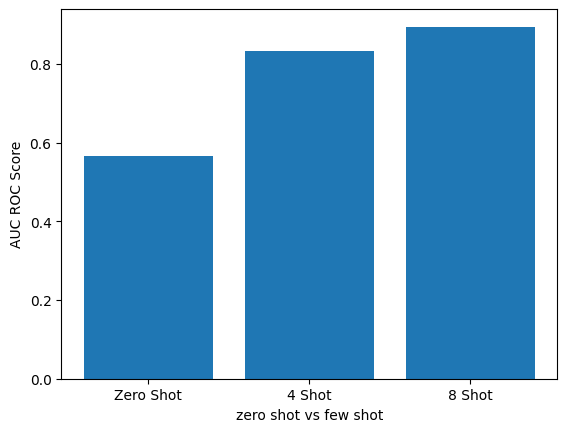

In [ ]:
zeroshot_fewshot_auc_roc = {'Zero Shot': 0.567, '4 Shot': 0.833, '8 Shot': 0.895}
x = list(zeroshot_fewshot_auc_roc.keys())
y = list(zeroshot_fewshot_auc_roc.values())
plt.bar(x, y)
plt.xlabel('zero shot vs few shot')
plt.ylabel('AUC ROC Score')

### Prompt Augmentations Result

Compare origin prompts, different prompt augmentations have very little impact of model performance. Out of them, make prompt shorter did hurt model performance a bit. It could because model not able to get enough information from prompt when it got shorter.

Text(0, 0.5, 'AUC ROC Score')

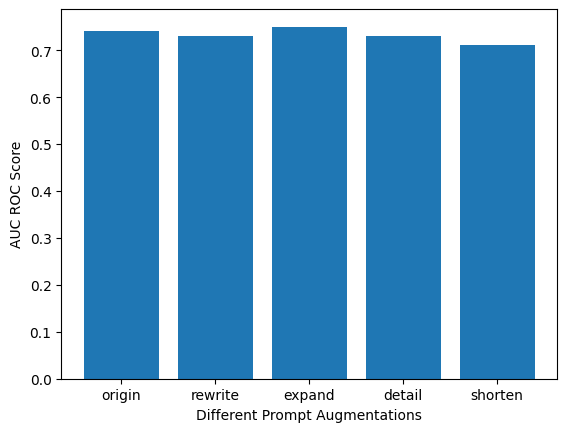

In [ ]:
prompt_augmentation_auc_roc = {'origin': 0.74, 'rewrite': 0.73, 'expand': 0.75, 'detail': 0.73, 'shorten': 0.71}
x = list(prompt_augmentation_auc_roc.keys())
y = list(prompt_augmentation_auc_roc.values())
plt.bar(x, y)
plt.xlabel('Different Prompt Augmentations')
plt.ylabel('AUC ROC Score')

### Prompt vs Molecule name only Ablation Result

In this ablation study we compare impact of using the original dataset prompt vs only mentioning molecule name in the prompt on correctly predicting task. Original prompt typically contains some introduction when ask a question while molecule name only prompt ask the same question while only provide molecule name.

For example,

* original prompt: "APR_HepG2_CellCycleArrest_24hr, is one of 10 assay component(s) measured or calculated from the APR_HepG2_24hr assay. It is designed to make measurements of cell phenotype, a form of morphology reporter, as detected with fluorescence intensity signals by HCS Fluorescent Imaging technology.Data from the assay component APR_HepG2_CellCycleArrest_24hr was analyzed into 2 assay endpoints. \nThis assay endpoint, APR_HepG2_CellCycleArrest_24h_dn, was analyzed in the negative fitting direction relative to DMSO as the negative control and baseline of activity. \nUsing a type of morphology reporter, measures of all nuclear dna for loss-of-signal activity can be used to understand the signaling at the pathway-level as they relate to the gene . \nFurthermore, this assay endpoint can be referred to as a primary readout, because this assay has produced multiple assay endpoints where this one serves a signaling function. \nTo generalize the intended target to other relatable targets, this assay endpoint is annotated to the \"cell cycle\" intended target family, where the subfamily is \"proliferation\". Is this molecule effective to this assay?"

* molecule name only prompt: "The assay name is APR_HepG2_CellCycleArrest_24hr. Is this molecule effective to this assay?"

Text(0, 0.5, 'AUC ROC Score')

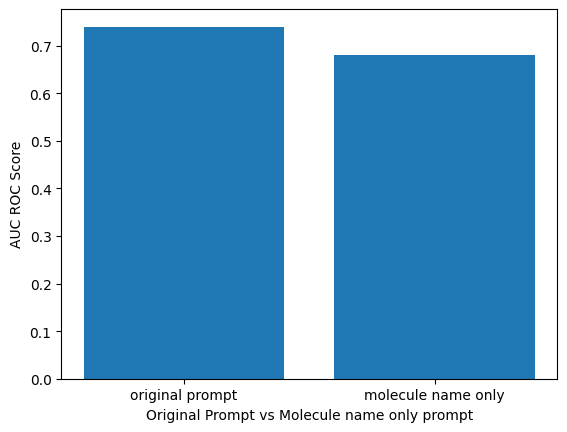

In [ ]:
ablated_prompt_auc_roc = {'original prompt': 0.74, 'molecule name only': 0.68}
x = list(ablated_prompt_auc_roc.keys())
y = list(ablated_prompt_auc_roc.values())
plt.bar(x, y)
plt.xlabel('Original Prompt vs Molecule name only prompt')
plt.ylabel('AUC ROC Score')

# Discussion

In this section,you should discuss your work and make future plan. The discussion should address the following questions:
  * Make assessment that the paper is reproducible or not.
  * Explain why it is not reproducible if your results are kind negative.
  * Describe “What was easy” and “What was difficult” during the reproduction.
  * Make suggestions to the author or other reproducers on how to improve the reproducibility.
  * What will you do in next phase.



### Implications of the experimental results

We are able to reproduce that zero-shot GIMLET model performs better than other zero-shot based models (KVPLM, MoMu, Galactica-125M, Galactica-1.3B).

We are able to reproduce that few-shot GIMLET model performs better than zero-shot GIMLET model.

However, we are not able to reproduce the exact RUC-AUC score reported in the paper. Our eval scores tend to be lower than what's reported in the paper but they are still higher than what the baseline models reported in the paper.

We think there are two reasons behind the discrepency:
* Due to the compute resources constraint and time limit on running the evals we only tried 20% of test dataset and 2% test dataset. In our experiments we found out 20% of test dataset reported higher RUC-AUC score than 2%. We expect if we run the full test dataset, we would see a higher RUC-AUC score.
* The paper and the code repo doesn't provide detail on the choosen hyperparameters used in the training. We used the largest batch size that can be supported in our TPU.

### What was easy

* The paper using standard huggingface data and training library, standard T5 transformer architecture and library and it use pytorch and pytorch geometric library, which make it easy to find and read the APIs to reproduce and easy to get and search for help with similar issues.

* The original repo provide clear instruction and scripts on where and how to get raw training and test data

### What was difficult

* Model itself is complex, it is a transfomer based with graph encoding model. Because the model propsed new attention mechanism to attend to both molecule and text embeddings. We bascially need to rewrite the multi-head attention component of the transformer. And the molecule encoding it is non-trival. It is hard to implement and understand the model.

* Because the model is complex, it is hard to train the model, which make it bascially impossible to train on CPU. We had to use 40GB TPU to train it.

### Recommendations to the original author

* Provide more detailed descriptions of model architecture.
* Provide more clear instructions on training and evals including the hyperparameters used in training and evals.